# Labo III
# Multinacional - Predicción de Ventas
### EDA general

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import os

# Optional for larger text and better visuals
sns.set(style="whitegrid", context="talk")

In [2]:
# Load the sales data (tab-delimited)
sales = pd.read_csv("datasets/sell-in.txt", sep="\t", dtype={"periodo": str})

# Load the stocks data (tab-delimited)
stocks = pd.read_csv("datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})

# Load the product information data (tab-delimited)
product_info = pd.read_csv("datasets/tb_productos.txt", sep="\t")

In [3]:
#carga productos a predecir
product_predict = pd.read_csv("datasets/product_id_apredecir201912.txt", sep="\t",header=0)

In [4]:
print("Sales Data:")
print(sales.shape)
print(sales.head(), "\n")

print("Stocks Data:")
print(stocks.head(), "\n")

print("Product Info Data:")
print(product_info.head())


Sales Data:
(2945818, 7)
  periodo  customer_id  product_id  plan_precios_cuidados  cust_request_qty  \
0  201701        10234       20524                      0                 2   
1  201701        10032       20524                      0                 1   
2  201701        10217       20524                      0                 1   
3  201701        10125       20524                      0                 1   
4  201701        10012       20524                      0                11   

   cust_request_tn       tn  
0          0.05300  0.05300  
1          0.13628  0.13628  
2          0.03028  0.03028  
3          0.02271  0.02271  
4          1.54452  1.54452   

Stocks Data:
  periodo  product_id  stock_final
0  201810       20524      1.61267
1  201810       20311      2.93657
2  201810       20654      6.83269
3  201810       21005      1.01338
4  201810       20974      0.34595 

Product Info Data:
    cat1      cat2         cat3   brand  sku_size  product_id  \
0  FOODS 

## Verificación de integridad de los datos

In [5]:
# 1. Verificación de existencia de nulos
print("\n1. Verificación de nulos:")
print("Productos:")
print(product_info.isnull().sum())
print("\nSell-in:")
print(sales.isnull().sum())
print("\nStocks:")
print(stocks.isnull().sum())
print("\nProductos a predecir:")
print(product_predict.isnull().sum())


1. Verificación de nulos:
Productos:
cat1           0
cat2           0
cat3           0
brand          0
sku_size       0
product_id     0
descripcion    0
dtype: int64

Sell-in:
periodo                  0
customer_id              0
product_id               0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
dtype: int64

Stocks:
periodo        0
product_id     0
stock_final    0
dtype: int64

Productos a predecir:
product_id    0
dtype: int64


Los dataset no presentan datos nulos

In [6]:
# 2. Verificar que existan los detalles de los productos en la tablas de productos
print("\n2. Verificar que existan los detalles de los productos en la tablas de productos:")
productos_sell_in = sales['product_id'].unique()
productos_en_tabla = product_info['product_id'].unique()
productos_a_predecir = product_predict['product_id'].unique()

#no_encontrados = [pid for pid in productos_sell_in if pid not in productos_en_tabla]
no_encontrados = pd.Series(productos_sell_in)[~pd.Series(productos_sell_in).isin(productos_en_tabla)]
#no_encontrados_a_predecir = [pid for pid in productos_a_predecir if pid not in productos_en_tabla]
no_encontrados_a_predecir = pd.Series(productos_a_predecir)[~pd.Series(productos_a_predecir).isin(productos_en_tabla)]

if len(no_encontrados) == 0:
    print("Todos los product_id de sell-in están presentes en tb_productos")
else:
    print(f"{len(no_encontrados)} product_id de sell-in no están en tb_productos")
    print("Ejemplos:", no_encontrados[:5])

    output_path = 'datasets/productos_entregados_sin_descripcion.txt'
    
    # Eliminar el archivo si ya existe
    if os.path.exists(output_path):
        os.remove(output_path)
        #print(f"Archivo existente {output_path} eliminado")
    

    # Guardar los nuevos datos
    with open(output_path, 'w') as f:
        # Escribir el encabezado
        f.write("product_id\n")  # Header
        for product_id in no_encontrados:
            f.write(f"{product_id}\n")


if len(no_encontrados_a_predecir) == 0:
    print("Todos los product_id a predecir están presentes en tb_productos")
else:
    print(f"{len(no_encontrados_a_predecir)} product_id de los productos a predecir no están en tb_productos")
    print("Ejemplos:", no_encontrados_a_predecir[:5])


2. Verificar que existan los detalles de los productos en la tablas de productos:
45 product_id de sell-in no están en tb_productos
Ejemplos: 87     21297
91     21249
115    21241
117    21225
161    21217
dtype: int64
Todos los product_id a predecir están presentes en tb_productos


Hay 45 productos de sobre los cuales se registran ventas pero no se tiene información referente a los mismos en tb_productos.txt

In [7]:
# Filtrar el dataframe por product_id = 21297
sales_filtrado = sales[sales['product_id'] == 21217]
sales_filtrado 


periodo  customer_id  product_id  plan_precios_cuidados  \
15286    201701        10227       21217                      0   
15287    201701        10197       21217                      0   
15288    201701        10205       21217                      0   
15289    201701        10061       21217                      0   
15290    201701        10003       21217                      0   
...         ...          ...         ...                    ...   
1498798  201806        10256       21217                      0   
1498799  201806        10056       21217                      0   
1498800  201806        10279       21217                      0   
1498801  201806        10361       21217                      0   
1498802  201806        10062       21217                      0   

         cust_request_qty  cust_request_tn       tn  
15286                   2          0.02102  0.02102  
15287                   1          0.00573  0.00573  
15288                   1          0.00573  0.00573  
15289                   2          0.00764  0.00764  
15290                   7          0.07835  0.07835  
...                   ...              ...      ...  
1498798                 1          0.00191  0.00191  
1498799                 1          0.00956  0.00956  
1498800                 1          0.00382  0.00382  
1498801                 1          0.00764  0.00764  
1498802                 1          0.00382  0.00382  

[318 rows x 7 columns]

In [8]:
# 3. Verificar relación cust_request_tn / cust_request_qty
print("\n3. Verificación de relación cust_request_tn / cust_request_qty:")

# Calcular la relación para cada producto
sales['relacion_tn_qty'] = (sales['cust_request_tn'] / sales['cust_request_qty'])

# Agrupar por producto y verificar si hay variación en la relación
relaciones_por_producto = sales.groupby('product_id')['relacion_tn_qty'].nunique()

productos_con_variacion = relaciones_por_producto[relaciones_por_producto > 1]

if len(productos_con_variacion) == 0:
    print("La relación cust_request_tn/cust_request_qty es consistente para todos los productos")
else:
    print(f"{len(productos_con_variacion)} productos tienen variación en la relación tn/qty")
    print("Ejemplos de productos con variación:")
    print(productos_con_variacion.head())
    
    # Mostrar ejemplos concretos
    ejemplo_producto = productos_con_variacion.index[0]
    print(f"\nEjemplo para product_id {ejemplo_producto}:")
    print(sales[sales['product_id'] == ejemplo_producto][['customer_id','product_id','cust_request_qty', 'cust_request_tn', 'relacion_tn_qty']].head())


3. Verificación de relación cust_request_tn / cust_request_qty:
1220 productos tienen variación en la relación tn/qty
Ejemplos de productos con variación:
product_id
20001    1423
20002    1469
20003    1155
20004    1021
20005     899
Name: relacion_tn_qty, dtype: int64

Ejemplo para product_id 20001:
       customer_id  product_id  cust_request_qty  cust_request_tn  \
44019        10001       20001                11         99.43861   
44020        10063       20001                 1          0.12312   
44021        10080       20001                 1          0.24625   
44022        10094       20001                 1          1.23123   
44023        10184       20001                 1          0.06716   

       relacion_tn_qty  
44019         9.039874  
44020         0.123120  
44021         0.246250  
44022         1.231230  
44023         0.067160  


In [9]:
def1= sales.groupby(['product_id', 'relacion_tn_qty']).count()

In [10]:
def1

periodo  customer_id  plan_precios_cuidados  \
product_id relacion_tn_qty                                                
20001      0.011190              21           21                     21   
           0.011195               2            2                      2   
           0.011200              42           42                     42   
           0.016790               2            2                      2   
           0.016805               1            1                      1   
...                             ...          ...                    ...   
21295      0.006990               1            1                      1   
21296      0.006510               1            1                      1   
21297      0.005790               1            1                      1   
21298      0.005730               1            1                      1   
21299      0.005460               1            1                      1   

                            cust_request_qty  cust_request_tn  tn  
product_id relacion_tn_qty                                         
20001      0.011190                       21               21  21  
           0.011195                        2                2   2  
           0.011200                       42               42  42  
           0.016790                        2                2   2  
           0.016805                        1                1   1  
...                                      ...              ...  ..  
21295      0.006990                        1                1   1  
21296      0.006510                        1                1   1  
21297      0.005790                        1                1   1  
21298      0.005730                        1                1   1  
21299      0.005460                        1                1   1  

[481030 rows x 6 columns]

In [59]:
# Filtrar filas de sales donde el product_id está en productos_con_variacion
sales[sales['product_id'].isin(productos_con_variacion.index)]

periodo  customer_id  product_id  plan_precios_cuidados  \
0       2017-01-01        10234       20524                      0   
1       2017-01-01        10032       20524                      0   
2       2017-01-01        10217       20524                      0   
3       2017-01-01        10125       20524                      0   
4       2017-01-01        10012       20524                      0   
...            ...          ...         ...                    ...   
2945813 2019-12-01        10105       20853                      0   
2945814 2019-12-01        10092       20853                      0   
2945815 2019-12-01        10006       20853                      0   
2945816 2019-12-01        10018       20853                      0   
2945817 2019-12-01        10020       20853                      0   

         cust_request_qty  cust_request_tn       tn  relacion_tn_qty  
0                       2          0.05300  0.05300         0.026500  
1                       1          0.13628  0.13628         0.136280  
2                       1          0.03028  0.03028         0.030280  
3                       1          0.02271  0.02271         0.022710  
4                      11          1.54452  1.54452         0.140411  
...                   ...              ...      ...              ...  
2945813                 1          0.02230  0.02230         0.022300  
2945814                 1          0.00669  0.00669         0.006690  
2945815                 7          0.02898  0.02898         0.004140  
2945816                 4          0.01561  0.01561         0.003903  
2945817                 2          0.01561  0.01561         0.007805  

[2945805 rows x 8 columns]

In [11]:
sales['periodo'] = pd.to_datetime(sales['periodo'], format='%Y%m')
stocks['periodo'] = pd.to_datetime(stocks['periodo'], format='%Y%m')


In [12]:
# Convertir la columna 'periodo' a tipo datetime con el formato correcto
sales['periodo'] = pd.to_datetime(sales['periodo'], format='%Y%m')

# Contar productos distintos vendidos en diciembre de 2019
cantidad_productos = sales[sales['periodo'].dt.year == 2019][sales['periodo'].dt.month == 12]['product_id'].nunique()

print("Cantidad de productos vendidos en 201912:", cantidad_productos)


Cantidad de productos vendidos en 201912: 927


C:\Users\paola\AppData\Local\Temp\ipykernel_23304\1374867162.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cantidad_productos = sales[sales['periodo'].dt.year == 2019][sales['periodo'].dt.month == 12]['product_id'].nunique()


In [19]:
# Count distinct products sold in December 2019
cantidad_productos = sales[sales['periodo'] == pd.Timestamp('2019-12-01')]['product_id'].nunique()
print("Cantidad de productos vendidos en 201912:", cantidad_productos)


Cantidad de productos vendidos en 201912: 927


In [39]:
# MONTHLY SALES

# Group by month and product, summing total sales in tons
monthly_sales = (
    sales.groupby(['periodo', 'product_id'])['tn']
    .sum()
    .reset_index()
)


In [40]:
# Elimino duplicados, y cargo con cero los meses sin ventas de algun producto

# Unique months and products
all_periods = monthly_sales['periodo'].drop_duplicates()
all_products = monthly_sales['product_id'].drop_duplicates()

# Cartesian product of all months and products
full_index = pd.MultiIndex.from_product(
    [all_periods, all_products],
    names=['periodo', 'product_id']
)

# Reindex and fill missing sales with 0
full_sales = (
    monthly_sales.set_index(['periodo', 'product_id'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)


In [41]:
print("Full Sales Matrix:")
print(full_sales.head())
print(f"Total rows (months × products): {len(full_sales)}")


Full Sales Matrix:
     periodo  product_id          tn
0 2017-01-01       20001   934.77222
1 2017-01-01       20002   550.15707
2 2017-01-01       20003  1063.45835
3 2017-01-01       20004   555.91614
4 2017-01-01       20005   494.27011
Total rows (months × products): 44388


In [42]:
# Merge stock_final into full_sales
data = full_sales.merge(stocks, on=['periodo', 'product_id'], how='left')

# Merge product info (static features)
data = data.merge(product_info, on='product_id', how='left')


In [69]:
# Agregamos la variable month
data['month'] = data['periodo'].dt.month

In [43]:
print("Merged Dataset Preview:")
print(data.head())


Merged Dataset Preview:
     periodo  product_id          tn  stock_final   cat1         cat2  \
0 2017-01-01       20001   934.77222          NaN     HC  ROPA LAVADO   
1 2017-01-01       20002   550.15707          NaN     HC  ROPA LAVADO   
2 2017-01-01       20003  1063.45835          NaN  FOODS     ADEREZOS   
3 2017-01-01       20004   555.91614          NaN  FOODS     ADEREZOS   
4 2017-01-01       20005   494.27011          NaN  FOODS     ADEREZOS   

       cat3    brand  sku_size  
0   Liquido    ARIEL    3000.0  
1   Liquido  LIMPIEX    3000.0  
2  Mayonesa   NATURA     475.0  
3  Mayonesa   NATURA     240.0  
4  Mayonesa   NATURA     120.0  


## EDA

In [44]:
#Total sales by month

monthly_total = data.groupby('periodo')['tn'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_total, x='periodo', y='tn')
plt.title("Total Sales Over Time (All Products)")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()


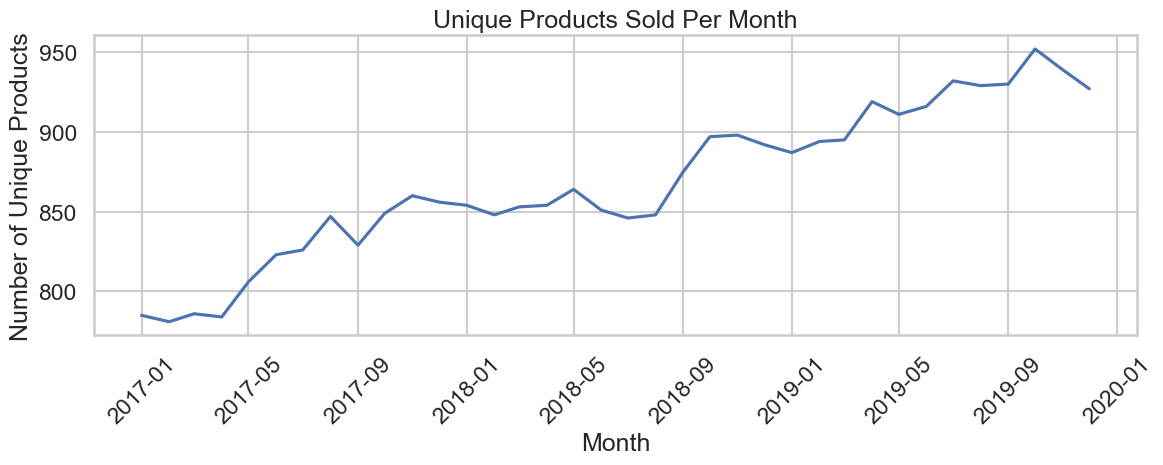

In [45]:
# Number of unique products sold by month

# Ensure 'periodo' is datetime
sales['month'] = sales['periodo'].dt.to_period('M').dt.to_timestamp()

# Group by month and count unique products sold
unique_products_per_month = (
    sales.groupby('month')['product_id']
    .nunique()
    .reset_index()
    .rename(columns={'product_id': 'unique_products_sold'})
)

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=unique_products_per_month, x='month', y='unique_products_sold')
plt.title("Unique Products Sold Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Unique Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


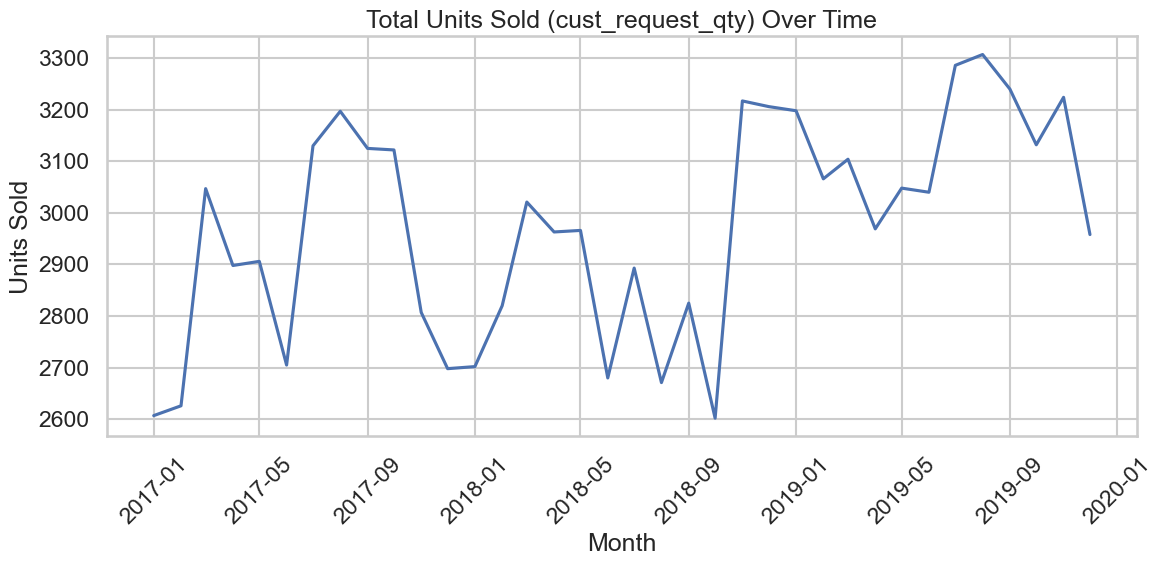

In [46]:
# Number of products sold by month

# Aggregate total units sold per month
monthly_units = (
    sales.groupby(data['periodo'].dt.to_period('M'))['cust_request_qty']
    .sum()
    .reset_index()
)

monthly_units['periodo'] = monthly_units['periodo'].dt.to_timestamp()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_units, x='periodo', y='cust_request_qty')
plt.title("Total Units Sold (cust_request_qty) Over Time")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


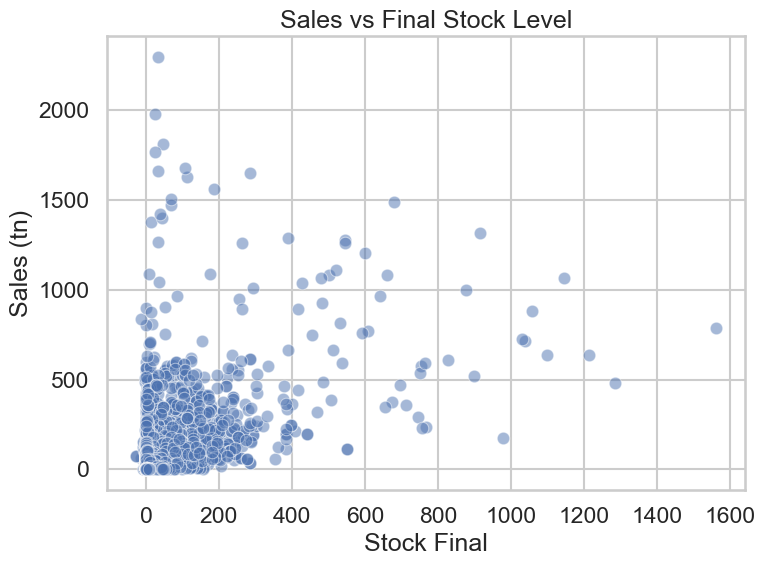

In [47]:
# Stocks vs sales

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='stock_final', y='tn', alpha=0.5)
plt.title("Sales vs Final Stock Level")
plt.xlabel("Stock Final")
plt.ylabel("Sales (tn)")
plt.tight_layout()
plt.show()


In [48]:
# Category sales over time

cat_monthly = (
    data.groupby(['periodo', 'cat1'])['tn']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=cat_monthly, x='periodo', y='tn', hue='cat1')
plt.title("Sales by Category Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.legend(title="Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


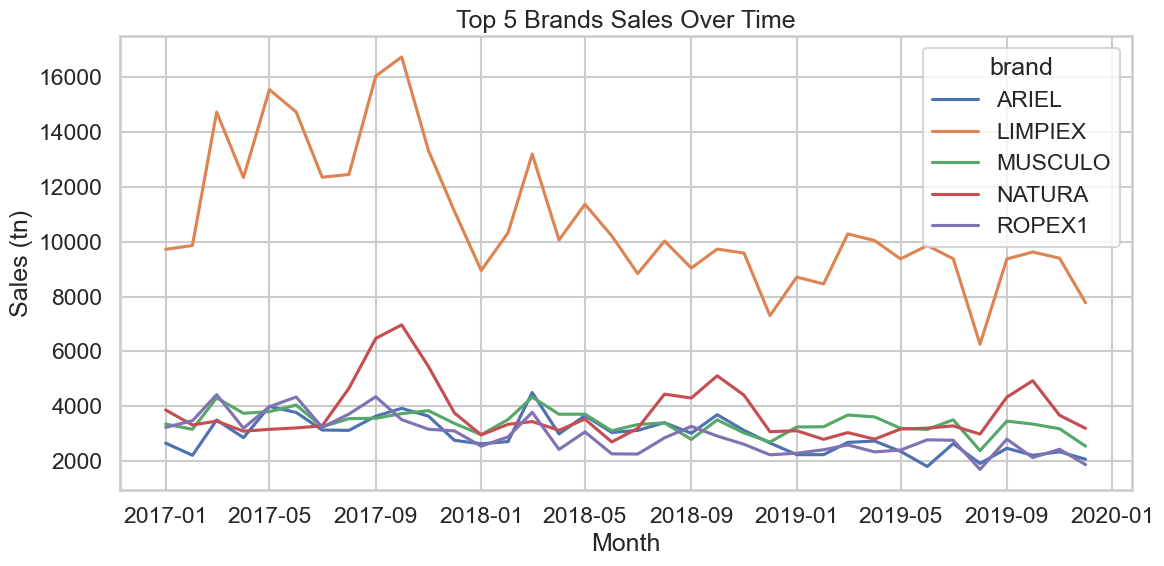

In [49]:
brand_trend = (
    data.groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

top_brands = brand_trend.groupby('brand')['tn'].sum().nlargest(5).index.tolist()
brand_trend_top = brand_trend[brand_trend['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=brand_trend_top, x='periodo', y='tn', hue='brand')
plt.title("Top 5 Brands Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.tight_layout()
plt.show()


In [50]:
# Products that take 90% of sales
# 1. Total sales per product
sales_per_product = data.groupby('product_id')['tn'].sum().reset_index()

# 2. Sort products by sales (descending)
sales_per_product = sales_per_product.sort_values(by='tn', ascending=False).reset_index(drop=True)

# 3. Calculate cumulative sales
sales_per_product['cumulative_tn'] = sales_per_product['tn'].cumsum()
total_sales = sales_per_product['tn'].sum()
sales_per_product['cumulative_pct'] = sales_per_product['cumulative_tn'] / total_sales

# 4. Find products that make up 90% of sales
top_90_products = sales_per_product[sales_per_product['cumulative_pct'] <= 0.9]


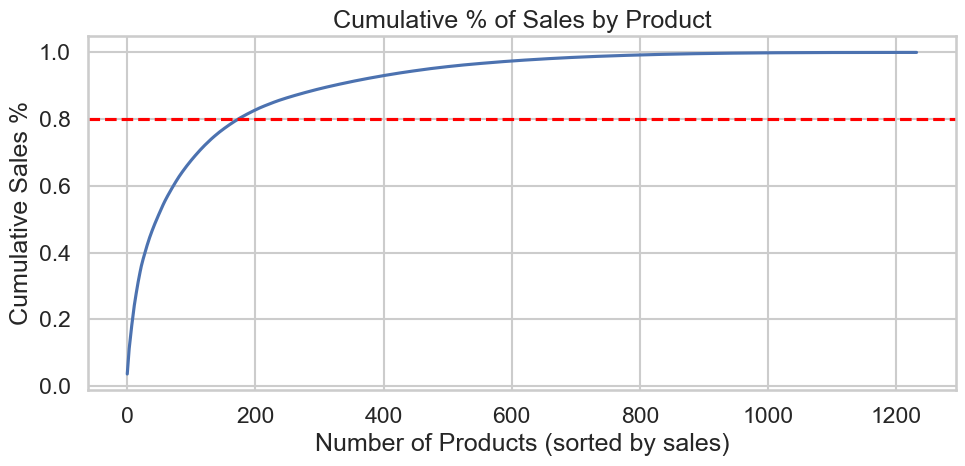

In [51]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_per_product, x=range(len(sales_per_product)), y='cumulative_pct')
plt.axhline(0.8, color='red', linestyle='--')
plt.title("Cumulative % of Sales by Product")
plt.xlabel("Number of Products (sorted by sales)")
plt.ylabel("Cumulative Sales %")
plt.tight_layout()
plt.show()


In [52]:
# Step 1: Merge brand info
data_with_brand = sales.merge(product_info[['product_id', 'brand']], on='product_id', how='left')

# Step 2: Aggregate sales per brand
sales_per_brand = (
    data_with_brand.groupby('brand')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Step 3: Calculate cumulative sales % per brand
sales_per_brand['cumulative_tn'] = sales_per_brand['tn'].cumsum()
total_sales = sales_per_brand['tn'].sum()
sales_per_brand['cumulative_pct'] = sales_per_brand['cumulative_tn'] / total_sales

# Step 4: Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_per_brand, x=range(len(sales_per_brand)), y='cumulative_pct')
plt.axhline(0.8, color='red', linestyle='--', label='80% Threshold')
plt.title("Cumulative % of Sales by Brand")
plt.xlabel("Number of Brands (sorted by sales)")
plt.ylabel("Cumulative Sales %")
plt.tight_layout()
plt.legend()
plt.show()

In [53]:
print(f"Total number of products: {len(sales_per_product)}")
print(f"Number of products that account for 90% of sales: {len(top_90_products)}")
print("\nTop products by total tn:")
print(top_90_products.head(10))


Total number of products: 1233
Number of products that account for 90% of sales: 321

Top products by total tn:
   product_id           tn  cumulative_tn  cumulative_pct
0       20001  50340.39558    50340.39558        0.036081
1       20010  37342.15836    87682.55394        0.062845
2       20002  36337.25439   124019.80833        0.088889
3       20003  32004.15274   156023.96107        0.111827
4       20021  25003.78252   181027.74359        0.129748
5       20020  24516.78008   205544.52367        0.147320
6       20004  24178.15379   229722.67746        0.164649
7       20005  23191.21852   252913.89598        0.181271
8       20007  22018.45234   274932.34832        0.197053
9       20022  21387.99848   296320.34680        0.212382


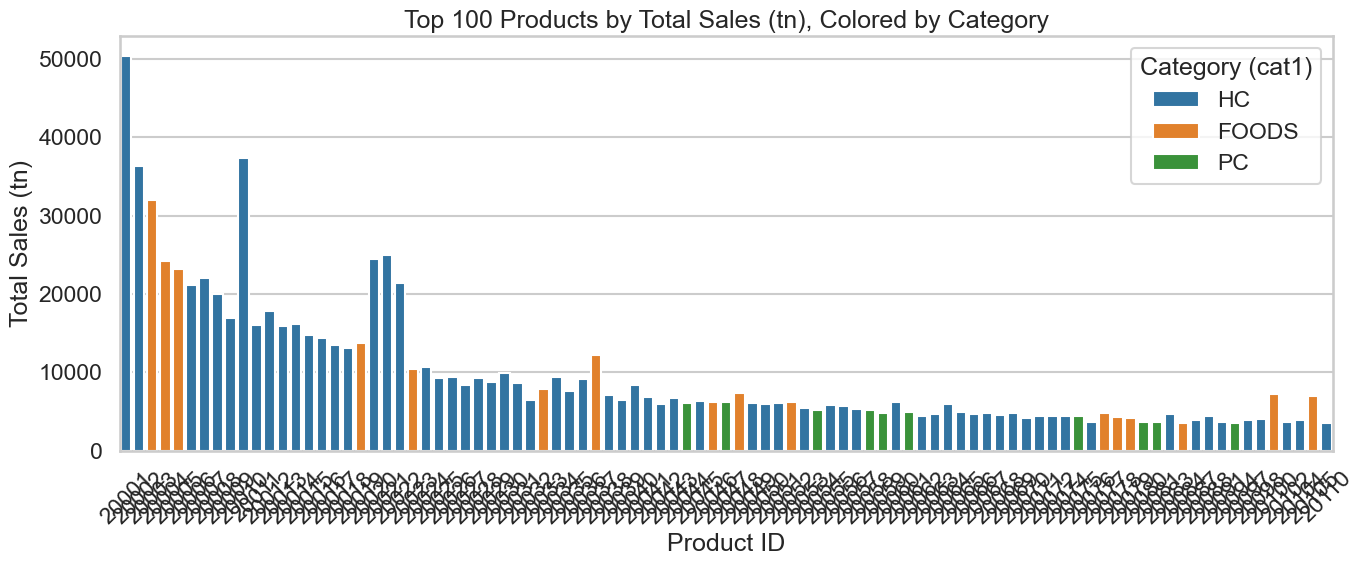

In [54]:
# Merge to add category (cat1) to top 90% products
top_90_merged = top_90_products.merge(product_info[['product_id', 'cat1']], on='product_id', how='left')

# Take the top 20 products by total sales
top_100 = top_90_merged.head(100)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_100,
    x='product_id',
    y='tn',
    hue='cat1',
    dodge=False,
    palette='tab10'
)

plt.title("Top 100 Products by Total Sales (tn), Colored by Category")
plt.xlabel("Product ID")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.legend(title="Category (cat1)")
plt.tight_layout()
plt.show()


In [55]:
# Step 1: Merge sales with product_info to get cat2
data_with_cat2 = data.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 2: Group by cat2 and sum total sales
cat2_sales = (
    data.groupby('cat2')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Step 3: Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=cat2_sales, x='cat2', y='tn', palette='tab10')
plt.title("Top-Selling Categories by cat2")
plt.xlabel("cat2")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\Miner\AppData\Local\Temp\ipykernel_15604\4190855226.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat2_sales, x='cat2', y='tn', palette='tab10')


<Figure size 1400x700 with 0 Axes>

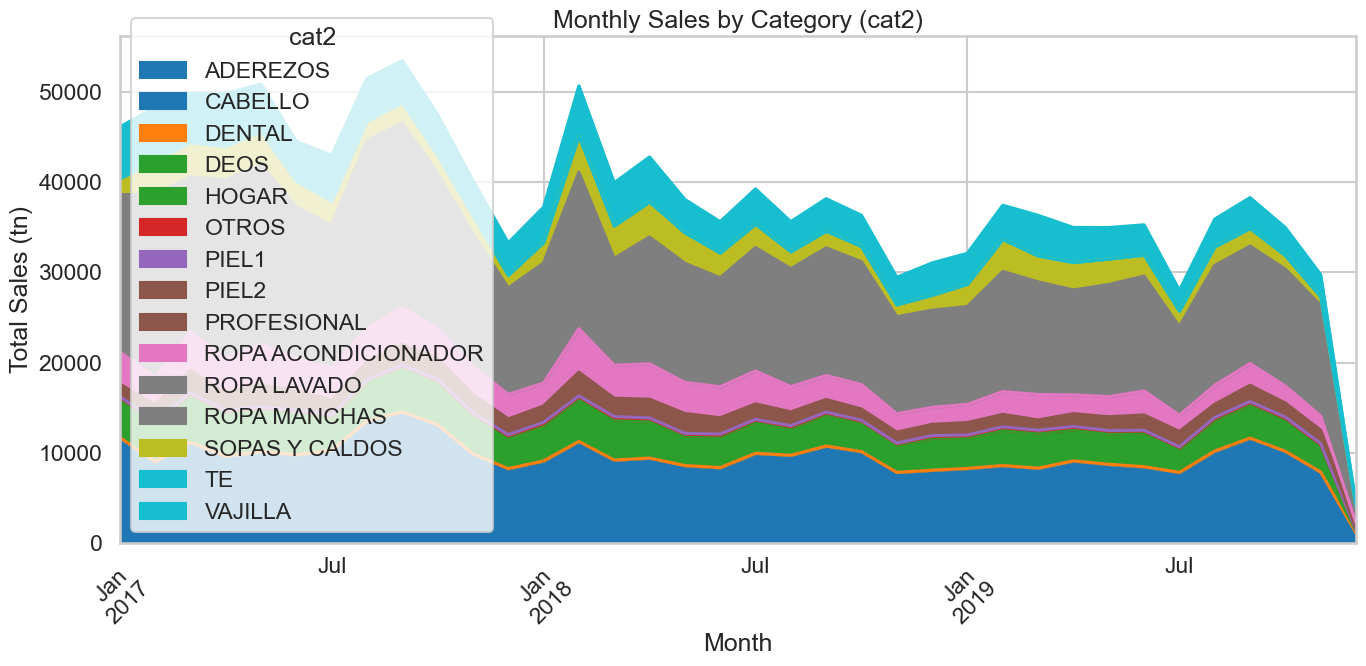

In [56]:
#Mismo grfico pero de lineas
# Step 1: Merge data with cat2
data_with_cat2 = data.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 2: Aggregate monthly sales by cat2
monthly_cat2 = (
    data.groupby([data_with_cat2['periodo'], 'cat2'])['tn']
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# Step 3: Plot stacked area chart
plt.figure(figsize=(14, 7))
monthly_cat2.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab10')
plt.title("Monthly Sales by Category (cat2)")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


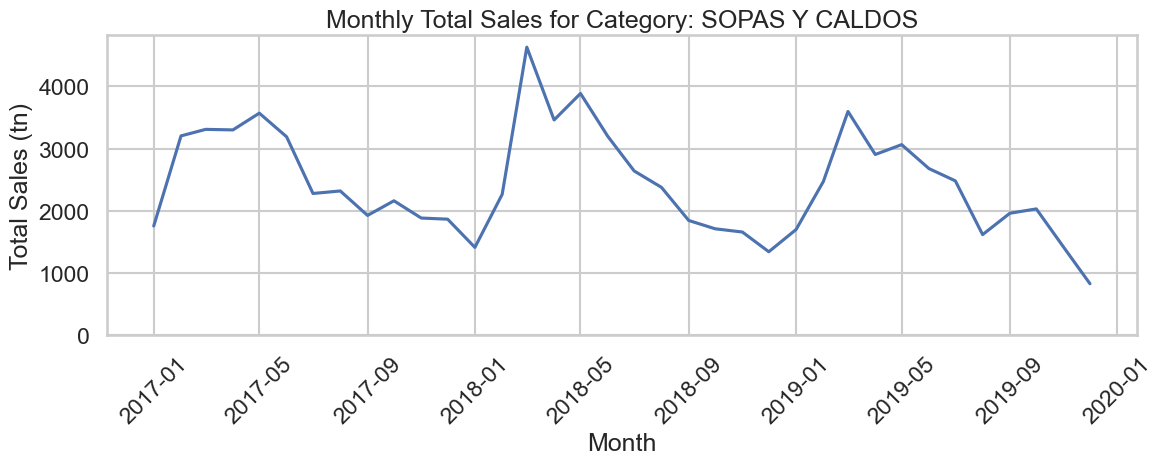

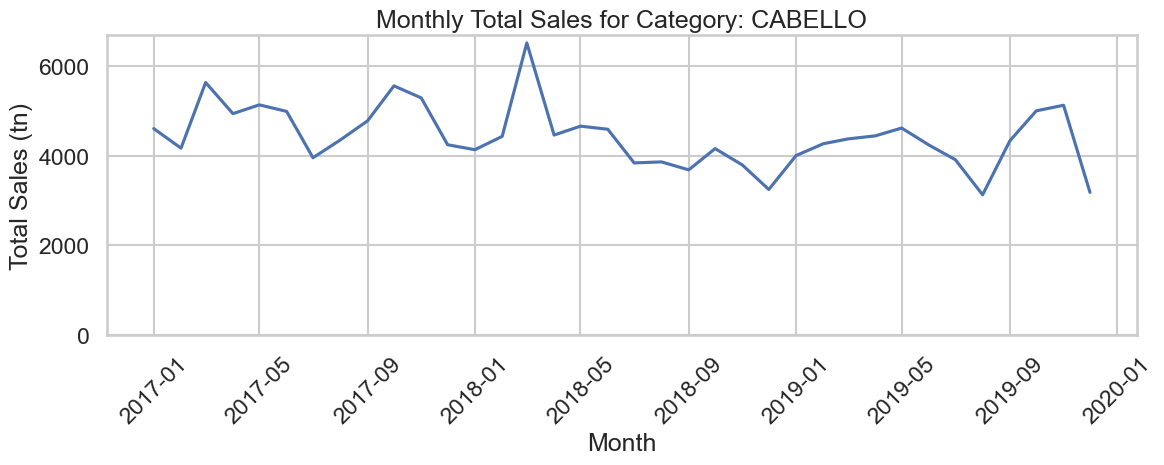

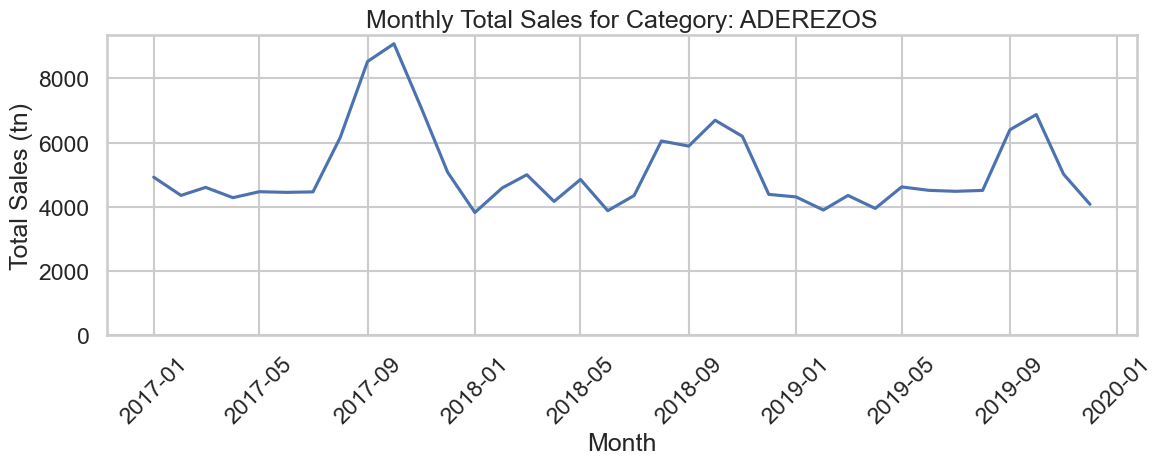

In [57]:
# Grafico de lineas de la suma de productos de SOPAS, CABELLO, ADEREZOS

# Merge category info
data_with_cat2 = sales.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Define target categories
target_categories = ['SOPAS Y CALDOS', 'CABELLO', 'ADEREZOS']

# Filter data for just those categories
filtered = data_with_cat2[data_with_cat2['cat2'].isin(target_categories)].copy()
filtered['month'] = filtered['periodo'].dt.to_period('M').dt.to_timestamp()

# Group by month and cat2 and sum total sales
monthly_cat2_sales = (
    filtered.groupby(['month', 'cat2'])['tn']
    .sum()
    .reset_index()
)

# Plot one line chart per category
for cat in target_categories:
    cat_data = monthly_cat2_sales[monthly_cat2_sales['cat2'] == cat]
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=cat_data, x='month', y='tn')
    plt.title(f"Monthly Total Sales for Category: {cat}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales (tn)")
    plt.xticks(rotation=45)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

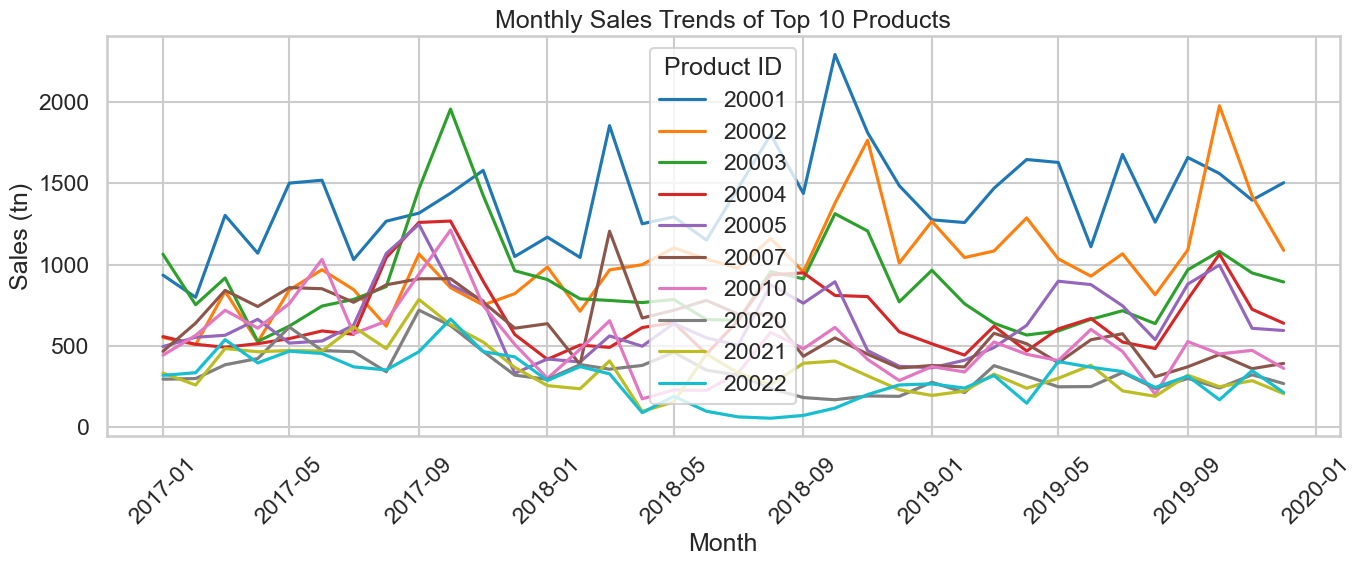

In [58]:
#Top 20 products trends over time

top_n = 10
top_product_ids = (
    data.groupby('product_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)

top_product_trend = data[data['product_id'].isin(top_product_ids)]

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=top_product_trend,
    x='periodo',
    y='tn',
    hue='product_id',
    palette='tab10'
)
plt.title(f"Monthly Sales Trends of Top {top_n} Products")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.legend(title="Product ID")
plt.tight_layout()
plt.show()



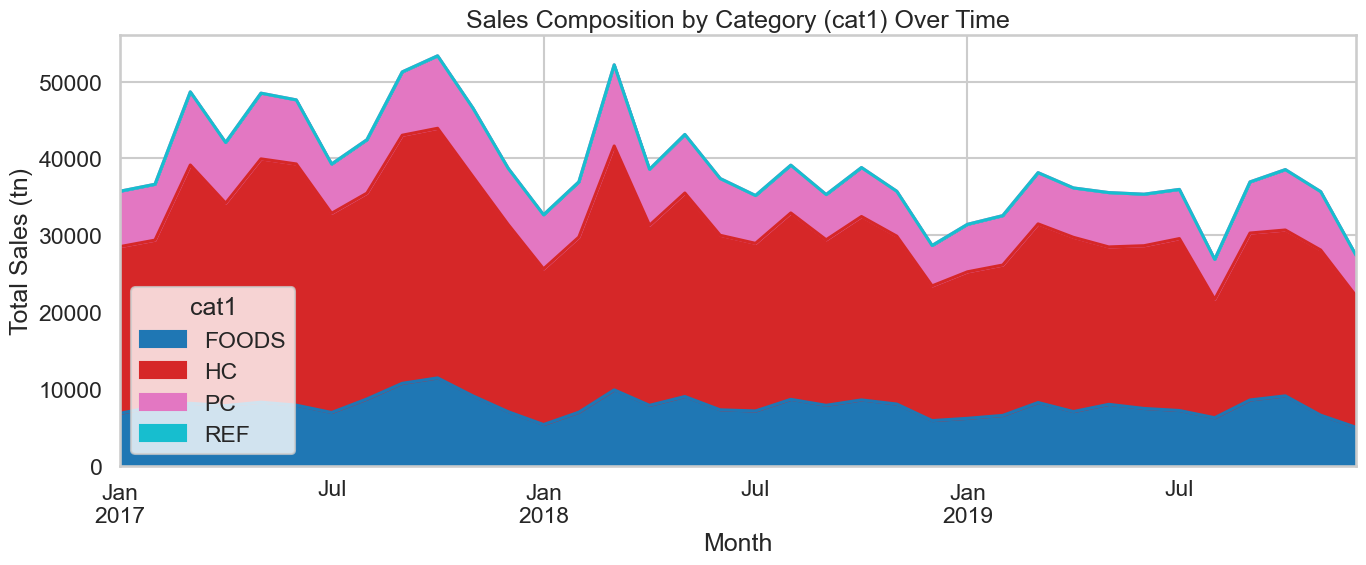

In [59]:
# Category composition over time

# Aggregate by period and cat1
cat_time = data.groupby(['periodo', 'cat1'])['tn'].sum().unstack().fillna(0)

# Plot as stacked area
cat_time.plot(kind='area', stacked=True, figsize=(14, 6), colormap='tab10')
plt.title("Sales Composition by Category (cat1) Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.tight_layout()
plt.show()


In [60]:
# Productos con high sales pero low stocks

stockouts = data[(data['stock_final'] < 0.1) & (data['tn'] > 0)]

print("Number of stockout events:", len(stockouts))
print(stockouts[['periodo', 'product_id', 'stock_final', 'tn']].head(10))


Number of stockout events: 1550
         periodo  product_id  stock_final         tn
26132 2018-10-01       20009      0.05580  596.92913
26189 2018-10-01       20063      0.02877  188.75855
26191 2018-10-01       20065      0.02457  177.73938
26216 2018-10-01       20092      0.04095   90.55683
26219 2018-10-01       20095     -0.02730   98.29376
26221 2018-10-01       20097      0.05576   74.65509
26276 2018-10-01       20160      0.02798   48.60553
26287 2018-10-01       20175      0.00000   45.43899
26288 2018-10-01       20176      0.00000   28.11723
26290 2018-10-01       20178     -0.02974   42.98745


C:\Users\Miner\AppData\Local\Temp\ipykernel_15604\3637450565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=brand_total_sales.head(20), x='brand', y='tn', palette='tab10')


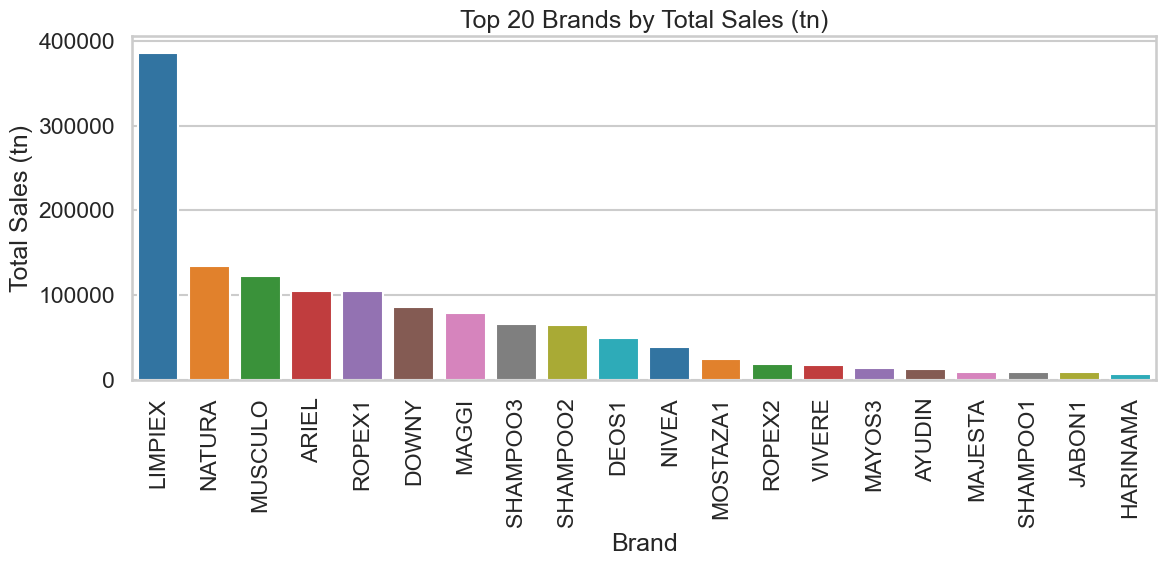

In [61]:
# Top brands for total sales

brand_total_sales = (
    data.groupby('brand')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(data=brand_total_sales.head(20), x='brand', y='tn', palette='tab10')
plt.title("Top 20 Brands by Total Sales (tn)")
plt.xlabel("Brand")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=90)  # Rotate labels vertically
plt.tight_layout()
plt.show()


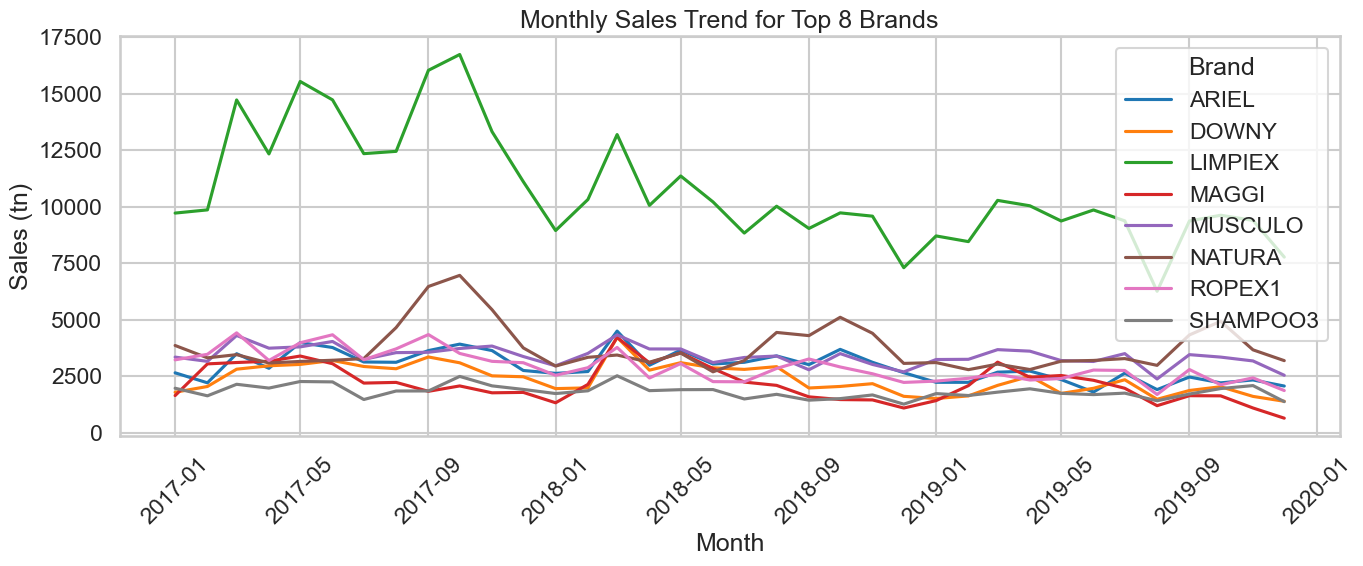

In [62]:
#Monthly sales for top brands

top_n = 8
top_brand_list = brand_total_sales['brand'].head(top_n).tolist()

brand_monthly = (
    data[data['brand'].isin(top_brand_list)]
    .groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=brand_monthly, x='periodo', y='tn', hue='brand', palette='tab10')
plt.title(f"Monthly Sales Trend for Top {top_n} Brands")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.legend(title="Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
# Sales decline/increase rate by brand

brand_time = (
    data.groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

brand_first_last = (
    brand_time.groupby('brand')
    .agg(first=('tn', 'first'), last=('tn', 'last'))
    .assign(pct_change=lambda df: (df['last'] - df['first']) / df['first'])
    .sort_values(by='pct_change', ascending=False)
)

print("Top growing brands:")
print(brand_first_last.head(5))

print("\nTop declining brands:")
print(brand_first_last.tail(5))



Top growing brands:
         first       last  pct_change
brand                                
ROPEX2     0.0  902.08275         inf
OFF        0.0    5.06529         inf
VICHY      0.0    0.10585         inf
SKIN1      0.0    0.64093         inf
FRANCIA    0.0    9.99344         inf

Top declining brands:
               first       last  pct_change
brand                                      
MAGGI     1650.68107  649.83663   -0.606322
ESPADOL     48.40814   15.64821   -0.676744
DEOS3       80.94587   23.37533   -0.711223
TWININGS     8.98416    0.36893   -0.958936
JABON1     305.84438    4.37389   -0.985699


In [64]:
#Products with mostly zero sales
sales_zero_ratio = (
    data.groupby('product_id')['tn']
    .apply(lambda x: (x == 0).sum() / len(x))
    .reset_index(name='pct_zero_sales')
    .sort_values(by='pct_zero_sales', ascending=False)
)

print("Products with highest percentage of zero-sales months:")
print(sales_zero_ratio.head(10))



Products with highest percentage of zero-sales months:
      product_id  pct_zero_sales
1232       21299        0.972222
1120       21169        0.972222
842        20854        0.972222
782        20792        0.972222
760        20770        0.972222
1218       21285        0.972222
1219       21286        0.972222
1220       21287        0.972222
1221       21288        0.972222
1209       21275        0.972222


Products with most frequent stockouts:
      product_id  pct_stockout_months
1132       21184             0.333333
1146       21201             0.250000
1155       21212             0.250000
1198       21264             0.222222
1076       21113             0.194444
51         20052             0.194444
320        20323             0.194444
236        20238             0.166667
690        20697             0.166667
447        20450             0.166667


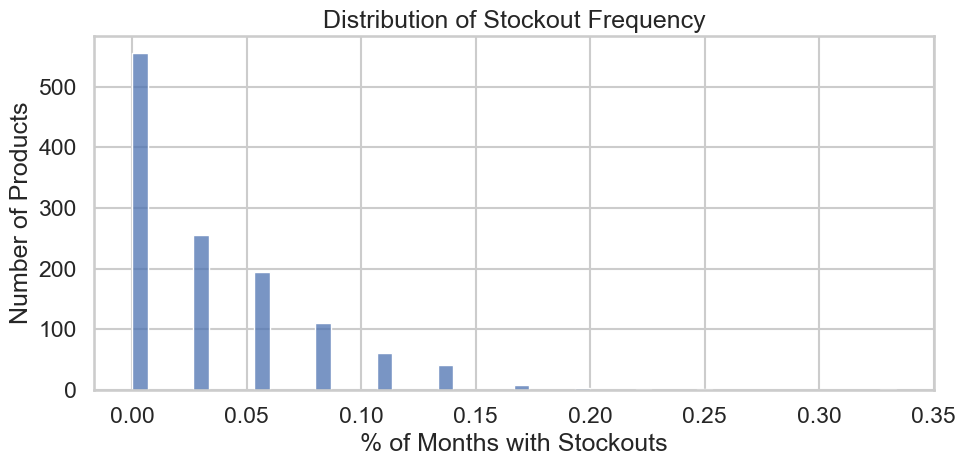

In [65]:
#Stockout frequency table

data['stockout'] = data['stock_final'] < 0.1

stockout_summary = (
    data.groupby('product_id')['stockout']
    .mean()
    .reset_index()
    .rename(columns={'stockout': 'pct_stockout_months'})
    .sort_values(by='pct_stockout_months', ascending=False)
)

print("Products with most frequent stockouts:")
print(stockout_summary.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(stockout_summary['pct_stockout_months'], bins=50)
plt.title("Distribution of Stockout Frequency")
plt.xlabel("% of Months with Stockouts")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

In [66]:
#Sales volatility per product

volatility = (
    data.groupby('product_id')['tn']
    .agg(['mean', 'std'])
    .reset_index()
)
volatility['coeff_var'] = volatility['std'] / volatility['mean']

volatility = volatility.sort_values(by='coeff_var', ascending=False)
print("Most volatile products (coefficient of variation):")
print(volatility[['product_id', 'coeff_var']].head(10))


Most volatile products (coefficient of variation):
      product_id  coeff_var
1231       21298        6.0
1229       21296        6.0
1228       21295        6.0
1120       21169        6.0
1222       21289        6.0
1218       21285        6.0
1232       21299        6.0
1230       21297        6.0
842        20854        6.0
782        20792        6.0


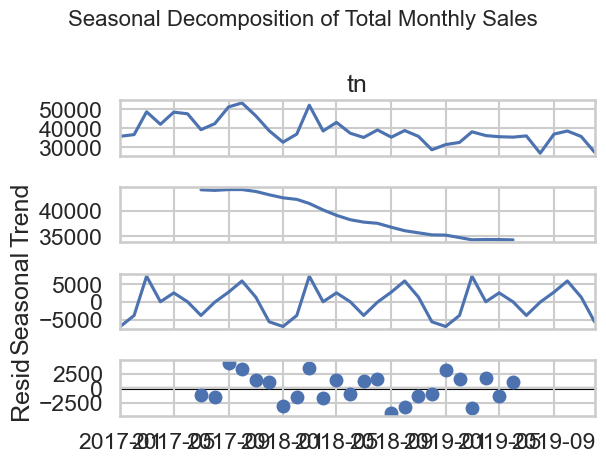

In [67]:
#Decomposition of total sales over time
# Decompose the time series to analyze trend, seasonality, and residuals

monthly_total = monthly_total.set_index('periodo')
monthly_total = monthly_total.asfreq('MS')  # ensure monthly frequency

decomp = seasonal_decompose(monthly_total['tn'], model='additive', period=12)

decomp.plot()
plt.suptitle("Seasonal Decomposition of Total Monthly Sales", fontsize=16)
plt.tight_layout()
plt.show()


In [70]:
#Most seasonal products

product_monthly = data.groupby(['product_id', 'month'])['tn'].mean().unstack()

# Calculate standard deviation across months
seasonality_strength = product_monthly.std(axis=1).sort_values(ascending=False)

top_seasonal_products = seasonality_strength.head(10)

print("Top 10 most seasonal products (high monthly variation):")
print(top_seasonal_products)


Top 10 most seasonal products (high monthly variation):
product_id
20003    250.953674
20001    200.681024
20004    196.414002
20005    180.412603
20002    179.455758
20010    121.268895
20007    120.438023
20019    117.650719
20006     98.610994
20012     94.650701
dtype: float64


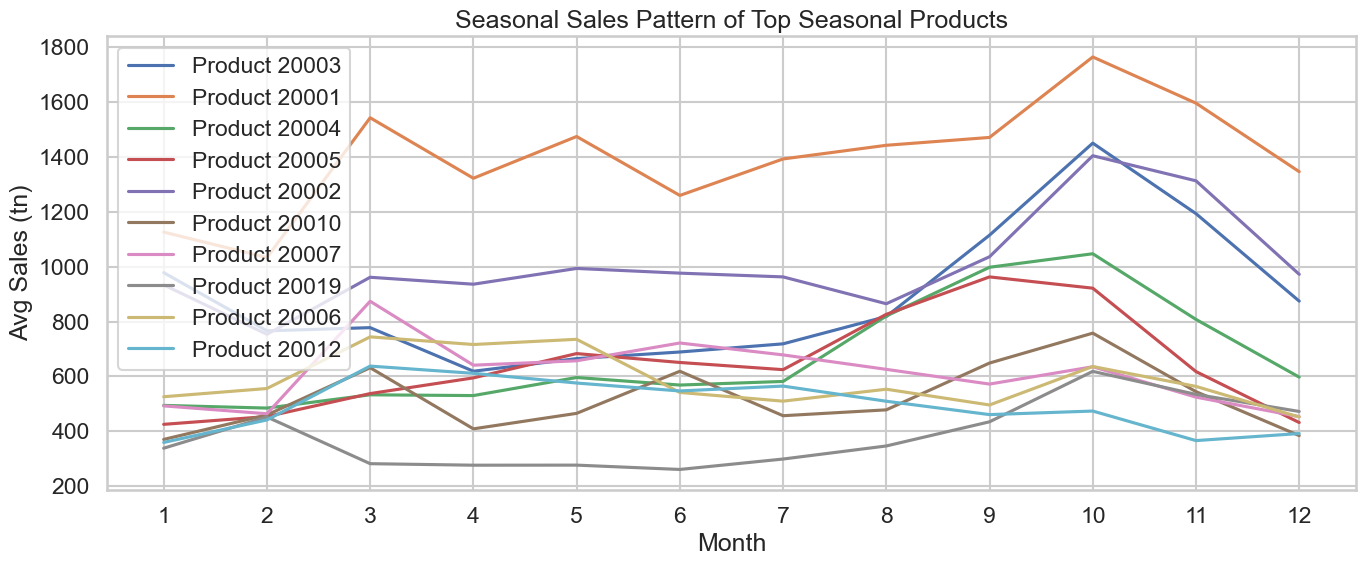

In [71]:
# Plotting a few of the most seasonal products
top_ids = top_seasonal_products.index[:10]

plt.figure(figsize=(14, 6))  # Wider figure

for pid in top_ids:
    plt.plot(product_monthly.columns, product_monthly.loc[pid], label=f'Product {pid}')

plt.title("Seasonal Sales Pattern of Top Seasonal Products")
plt.xlabel("Month")
plt.ylabel("Avg Sales (tn)")
plt.xticks(product_monthly.columns)  # Ensure months are labeled
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Miner\AppData\Local\Temp\ipykernel_15604\2125222133.py:13: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(product_monthly.columns, product_monthly.loc[pid], label=label)


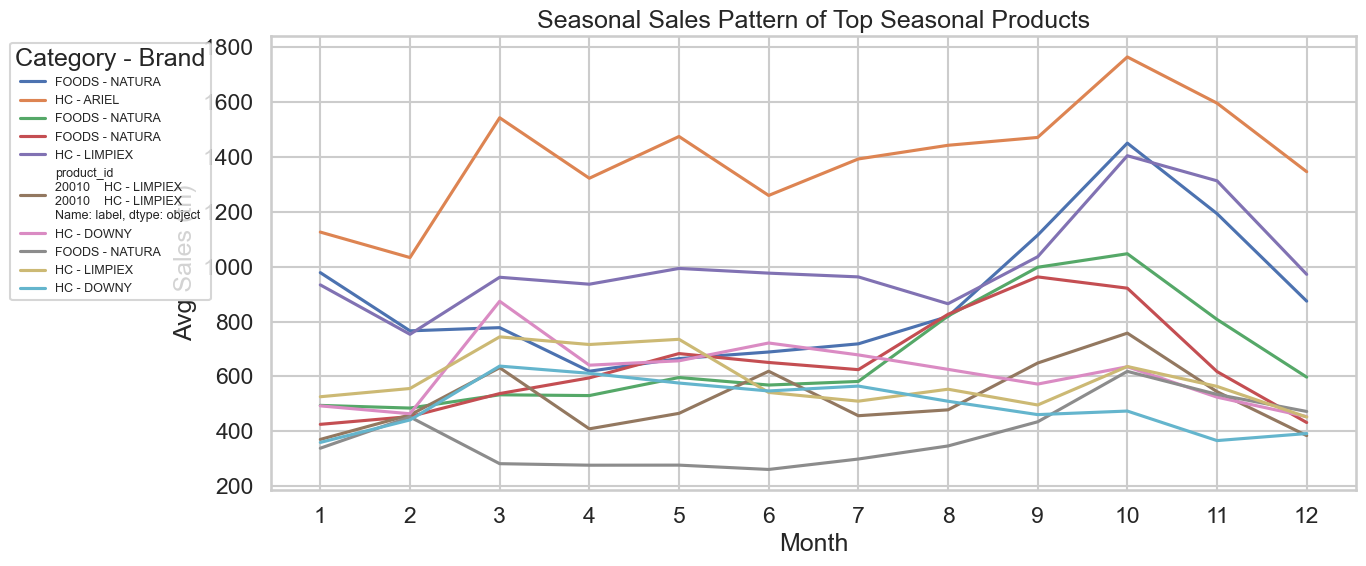

In [72]:
# Step 1: Get top seasonal product IDs
top_ids = top_seasonal_products.index[:10]

# Step 2: Merge with product_info to get labels
label_lookup = product_info.set_index('product_id').loc[top_ids][['cat1', 'brand']]
label_lookup['label'] = label_lookup['cat1'] + ' - ' + label_lookup['brand']

# Step 3: Plot with labeled lines
plt.figure(figsize=(14, 6))

for pid in top_ids:
    label = label_lookup.loc[pid, 'label']
    plt.plot(product_monthly.columns, product_monthly.loc[pid], label=label)

plt.title("Seasonal Sales Pattern of Top Seasonal Products")
plt.xlabel("Month")
plt.ylabel("Avg Sales (tn)")
plt.xticks(product_monthly.columns)

# Place the legend to the left, with smaller font
plt.legend(
    title="Category - Brand",
    prop={'size': 9},
    bbox_to_anchor=(-0.05, 1),  # move legend left of plot
    loc='upper right'
)

plt.tight_layout()
plt.show()


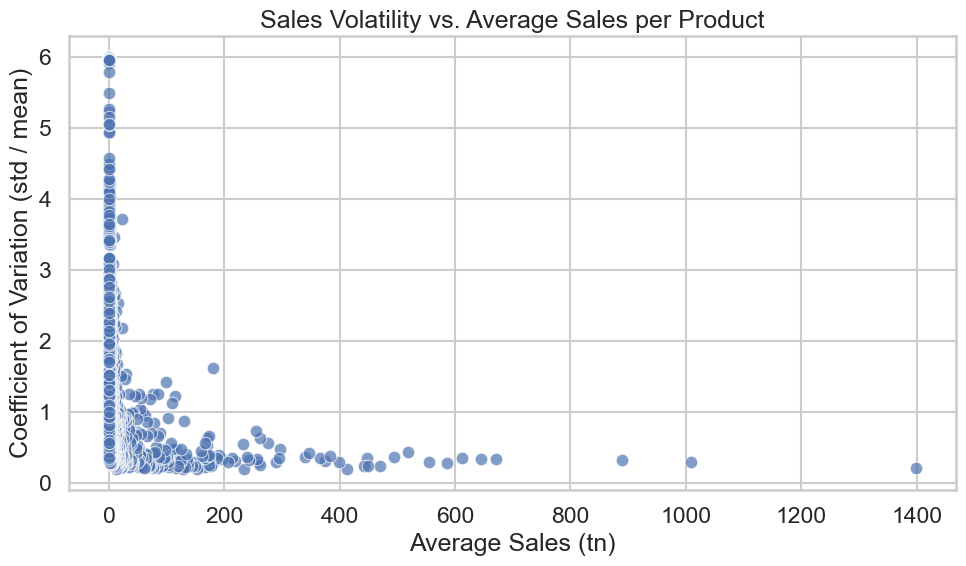

In [73]:
#Volatility vs sales

volatility_df = data.groupby('product_id')['tn'].agg(['mean', 'std']).reset_index()
volatility_df['cv'] = volatility_df['std'] / (volatility_df['mean'] + 1e-6)  # avoid division by zero

plt.figure(figsize=(10, 6))
sns.scatterplot(data=volatility_df, x='mean', y='cv', alpha=0.7)
plt.title("Sales Volatility vs. Average Sales per Product")
plt.xlabel("Average Sales (tn)")
plt.ylabel("Coefficient of Variation (std / mean)")
plt.tight_layout()
plt.show()


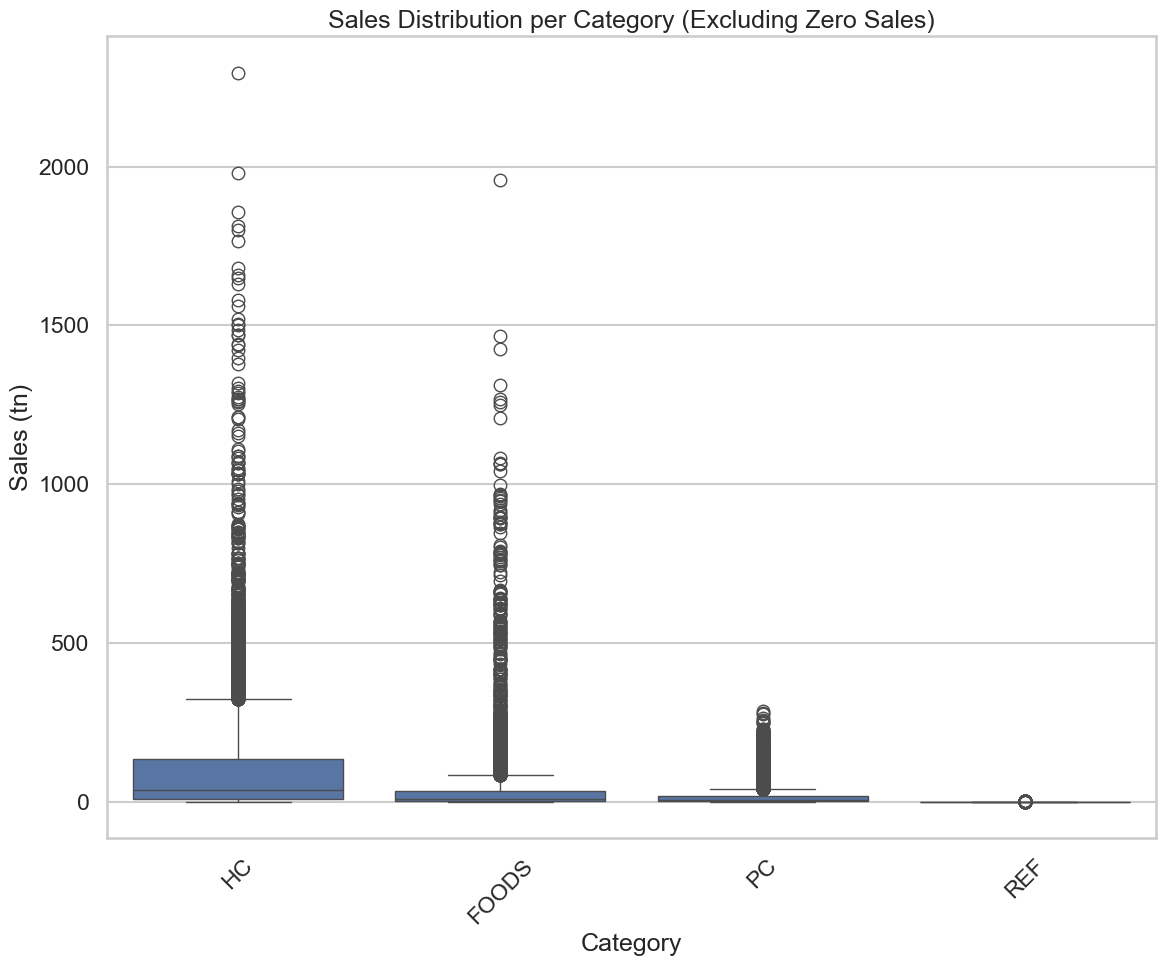

In [74]:
#Sales per category (boxplot)

plt.figure(figsize=(12, 10))
sns.boxplot(data=data[data['tn'] > 0], x='cat1', y='tn')
plt.title("Sales Distribution per Category (Excluding Zero Sales)")
plt.xlabel("Category")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


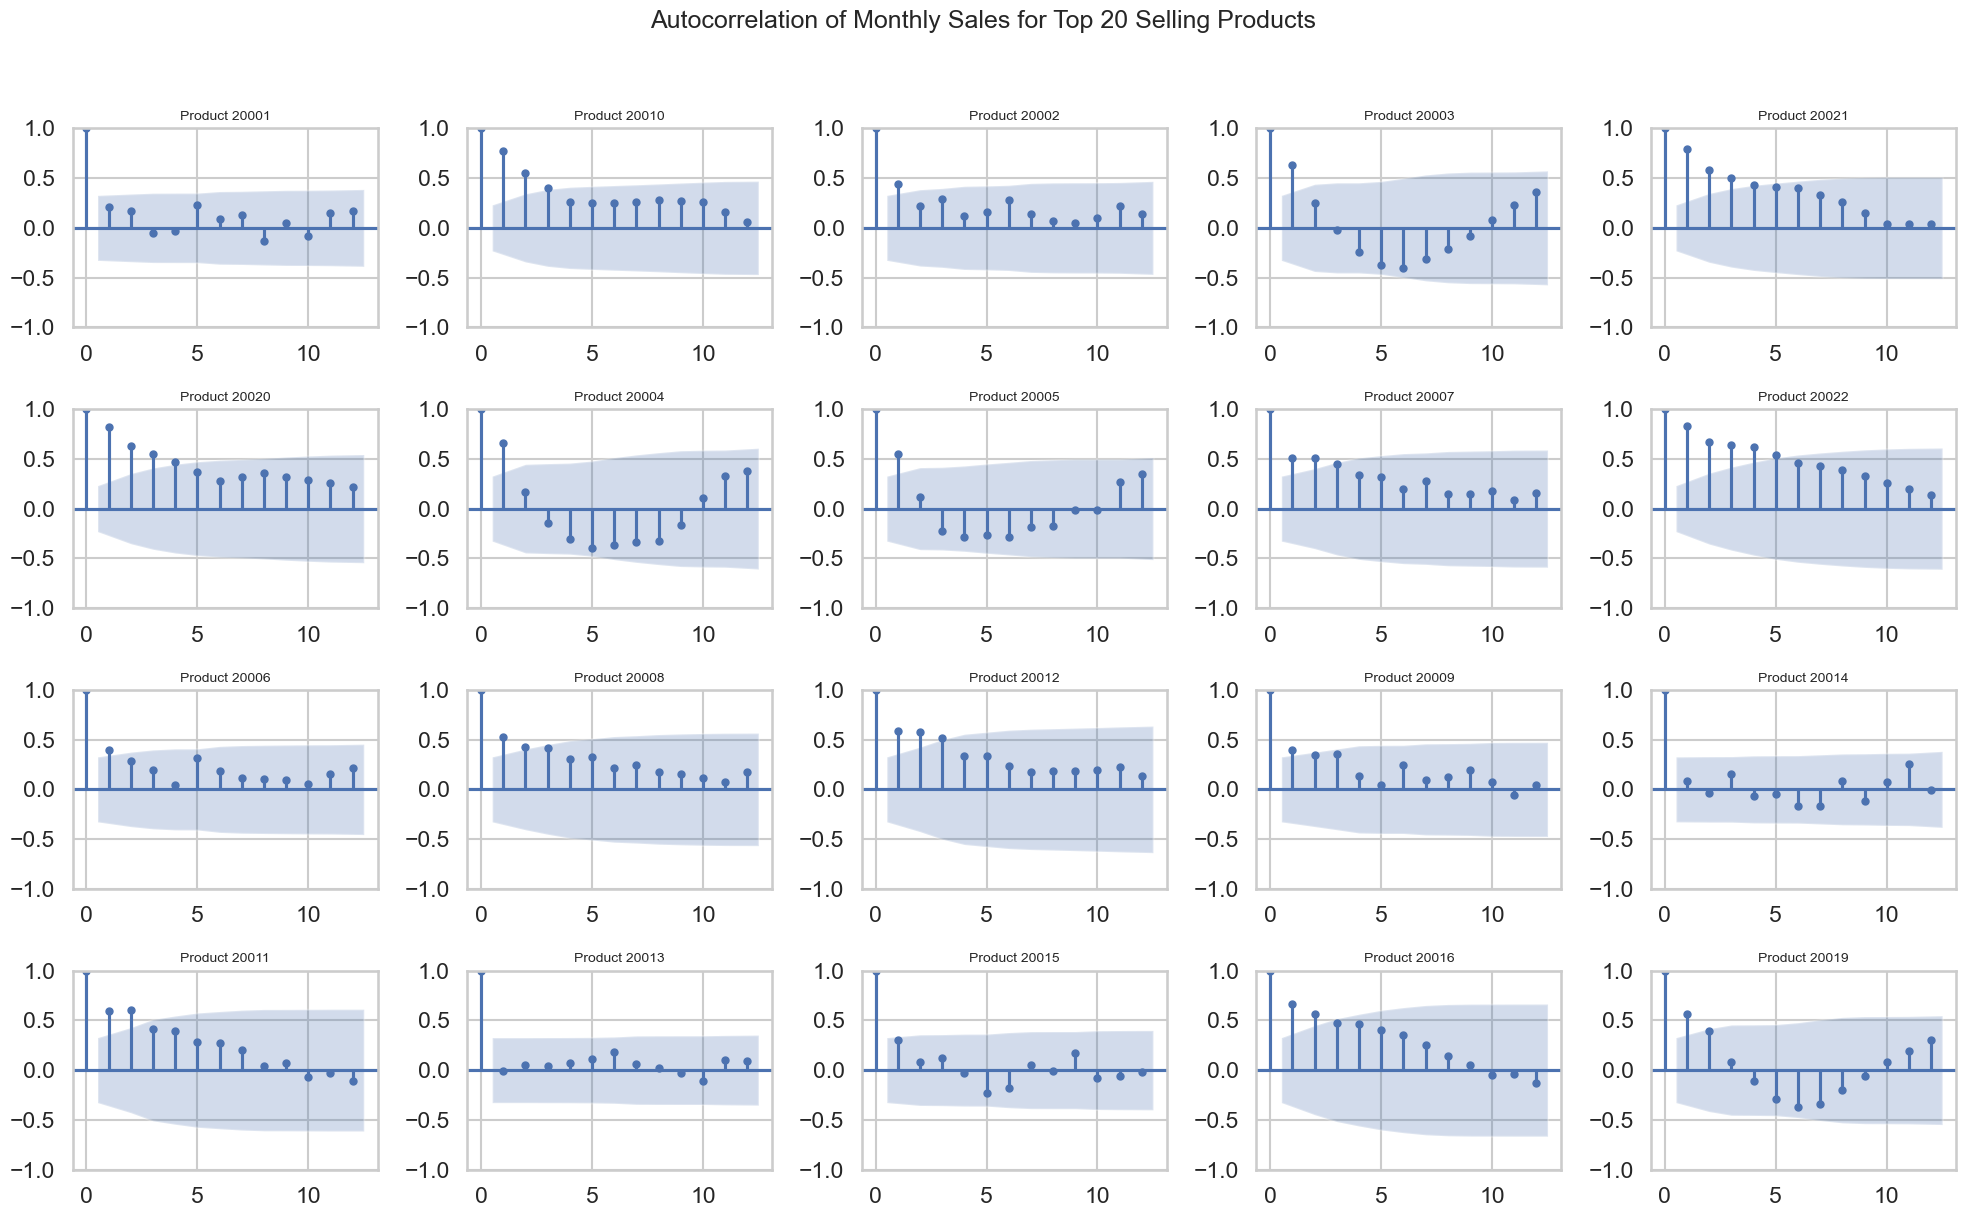

In [75]:
#Autocorrelation for top selling products

top_n = 20
top_products = data.groupby('product_id')['tn'].sum().nlargest(top_n).index.tolist()

# Set up 4 rows × 5 columns
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
axes = axes.flatten()

for i, pid in enumerate(top_products):
    sales_series = (
        data[data['product_id'] == pid]
        .sort_values('periodo')['tn']
        .reset_index(drop=True)
    )
    
    plot_acf(sales_series, lags=12, ax=axes[i])
    axes[i].set_title(f'Product {pid}', fontsize=10)

# Turn off unused axes (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Autocorrelation of Monthly Sales for Top 20 Selling Products", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


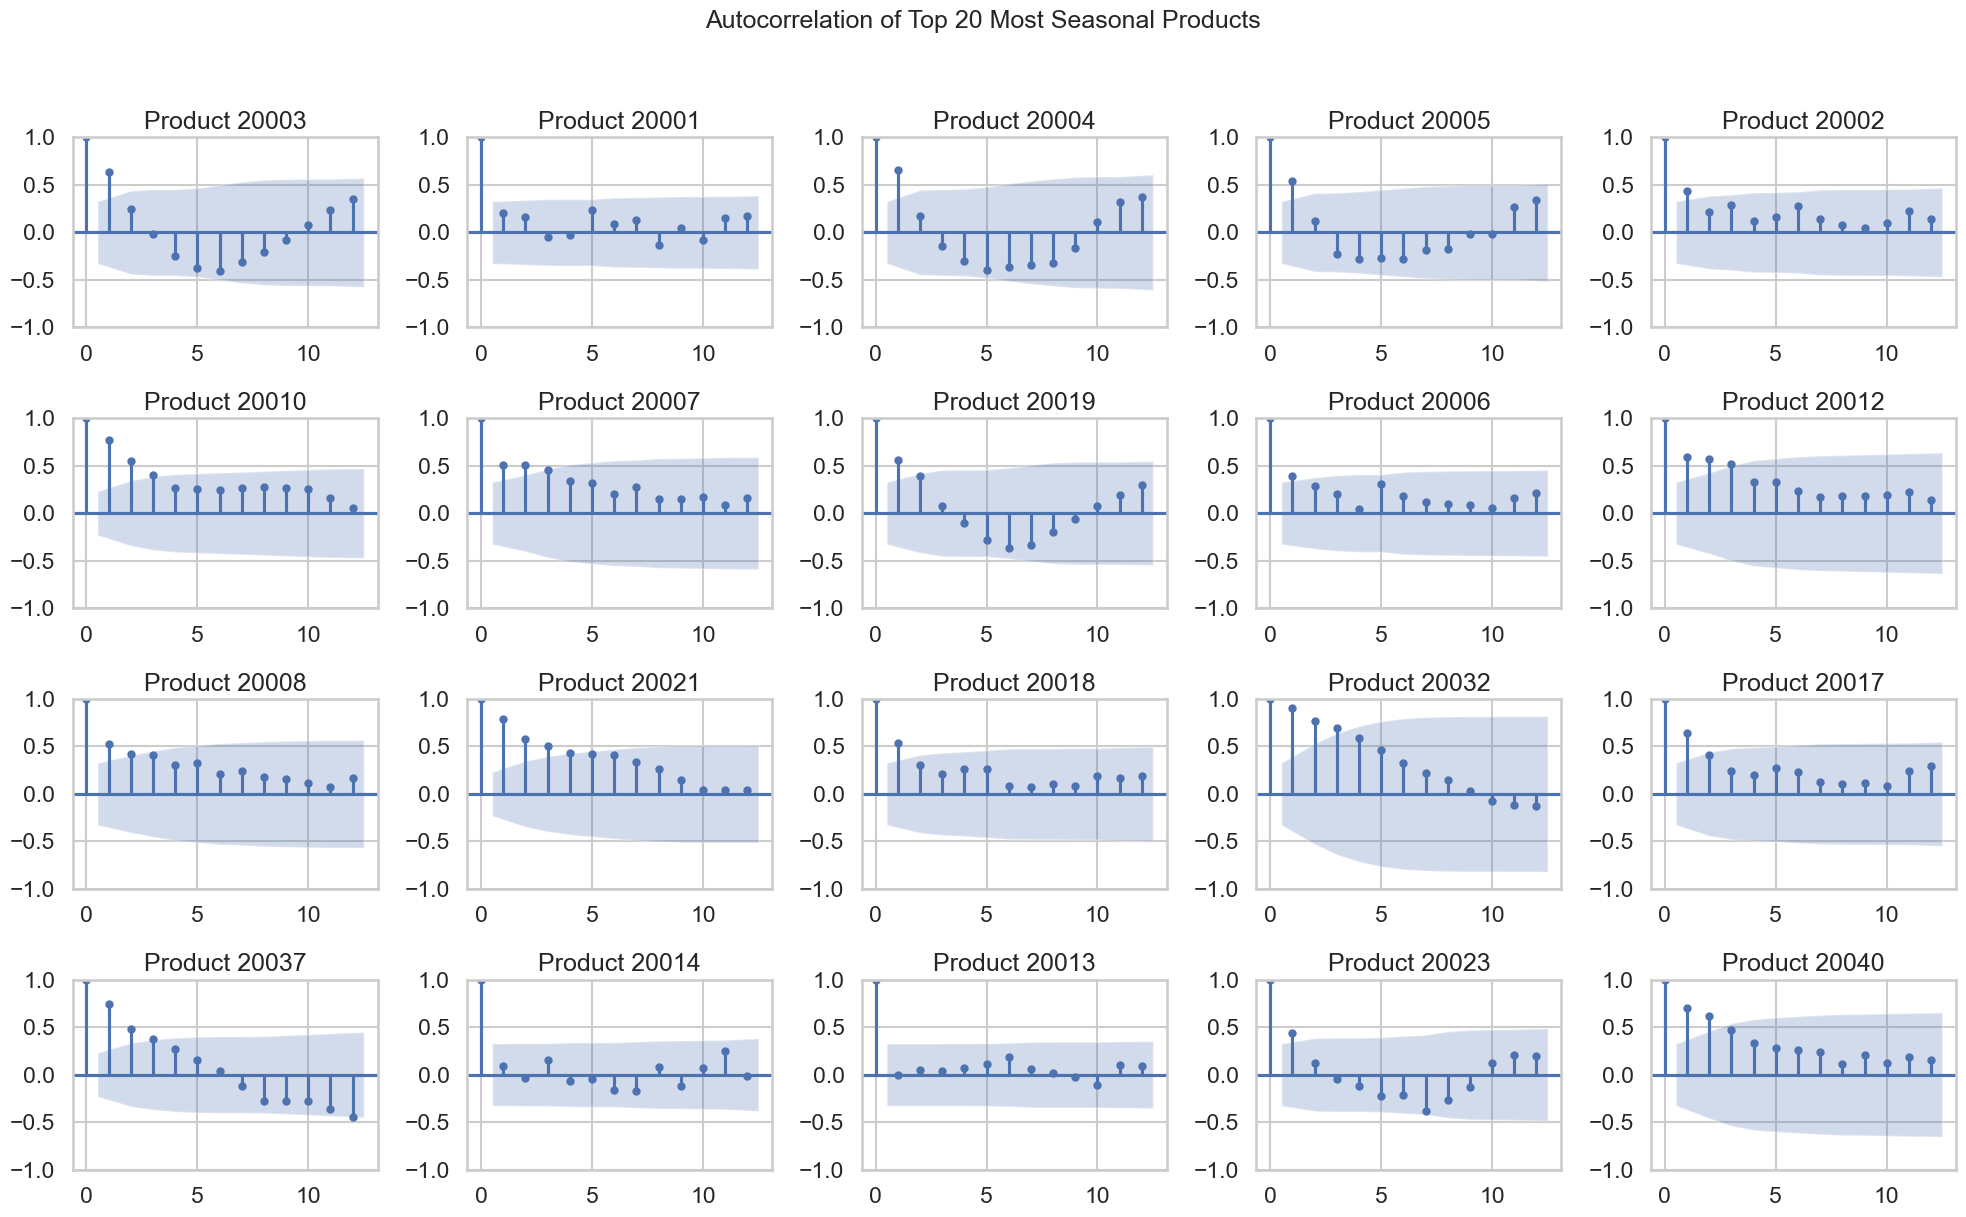

In [76]:
#Autocorrelation for most seasonal products
product_monthly = data.groupby(['product_id', 'month'])['tn'].mean().unstack(fill_value=0)
seasonality_strength = product_monthly.std(axis=1).sort_values(ascending=False)
top_20_seasonal_ids = seasonality_strength.head(20).index.tolist()


# Set up 4 rows × 5 columns for 20 plots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
axes = axes.flatten()  # flatten 2D array of axes for easy indexing

# Loop through top 20 products
for i, pid in enumerate(top_20_seasonal_ids):
    sales_series = (
        data[data['product_id'] == pid]
        .sort_values('periodo')['tn']
        .reset_index(drop=True)
    )

    plot_acf(sales_series, lags=12, ax=axes[i])
    axes[i].set_title(f'Product {pid}')

# Turn off any unused subplots (if less than 20)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Autocorrelation of Top 20 Most Seasonal Products", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


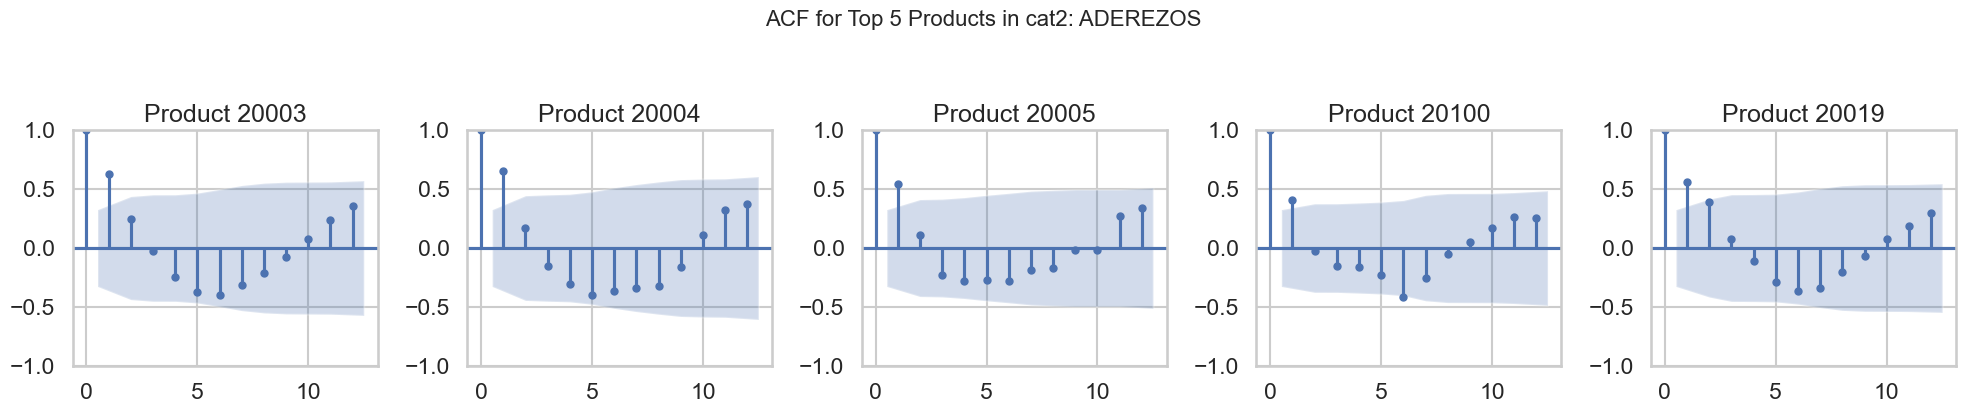

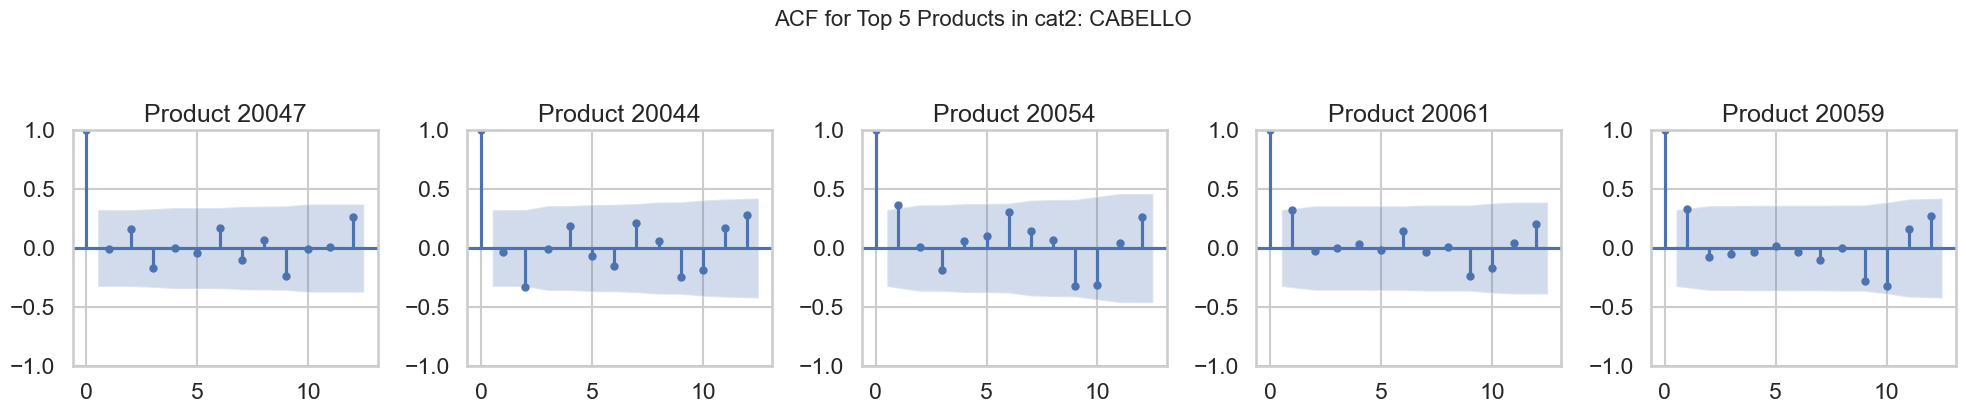

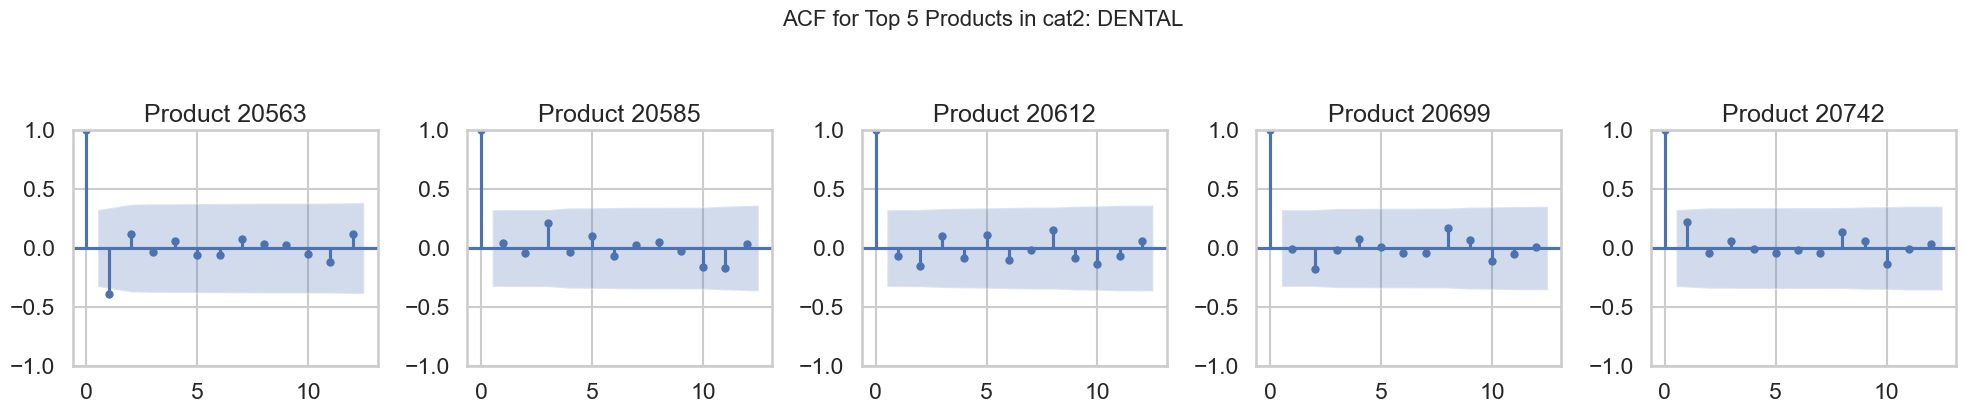

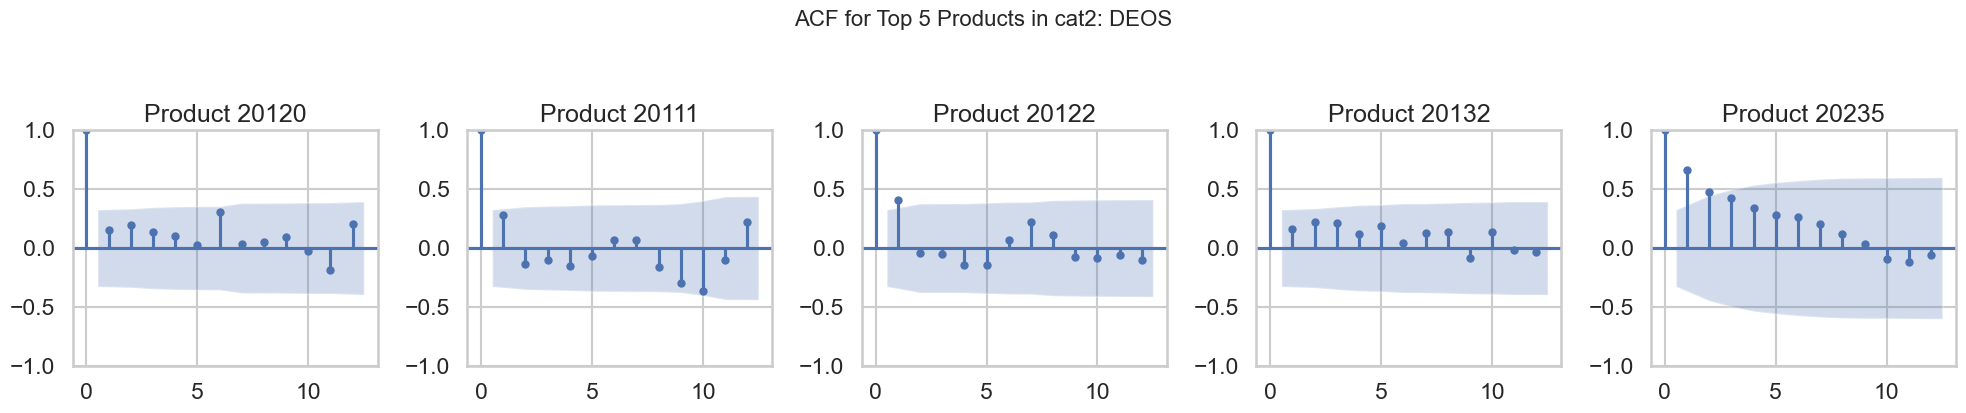

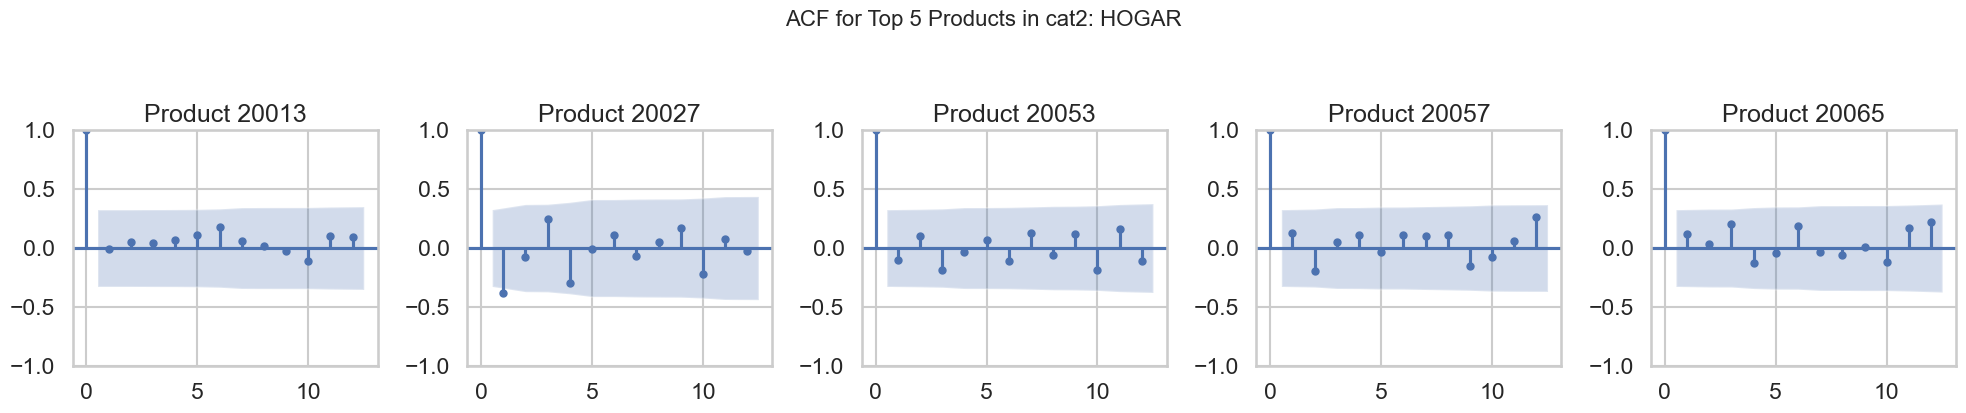

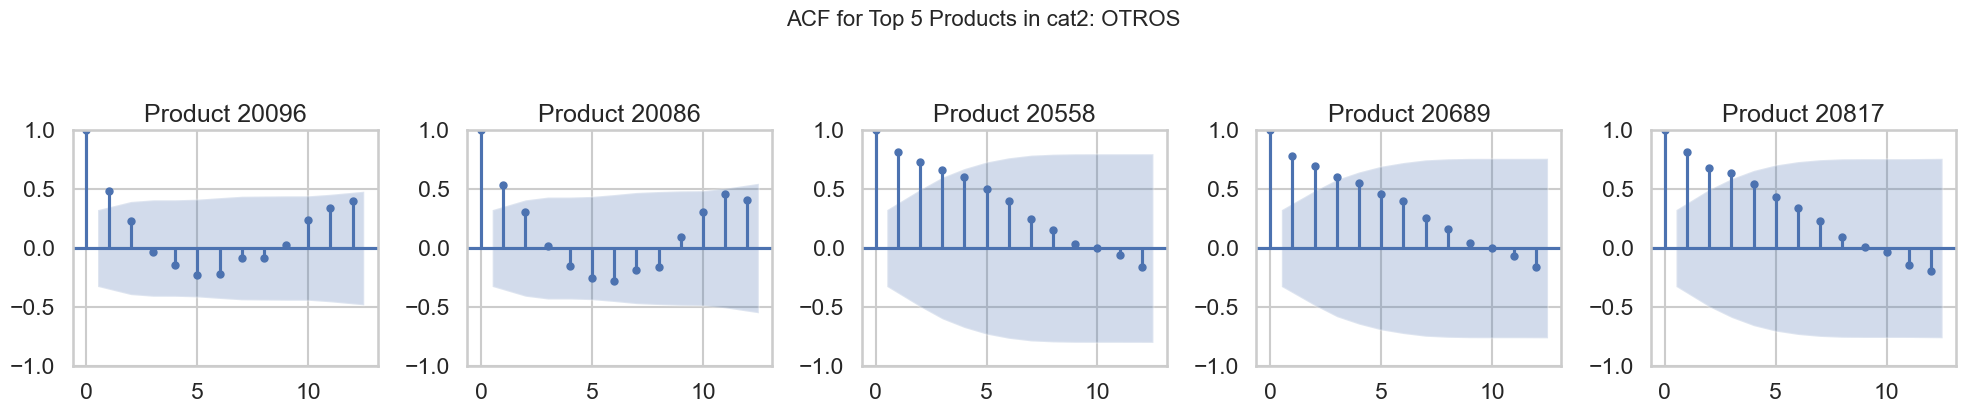

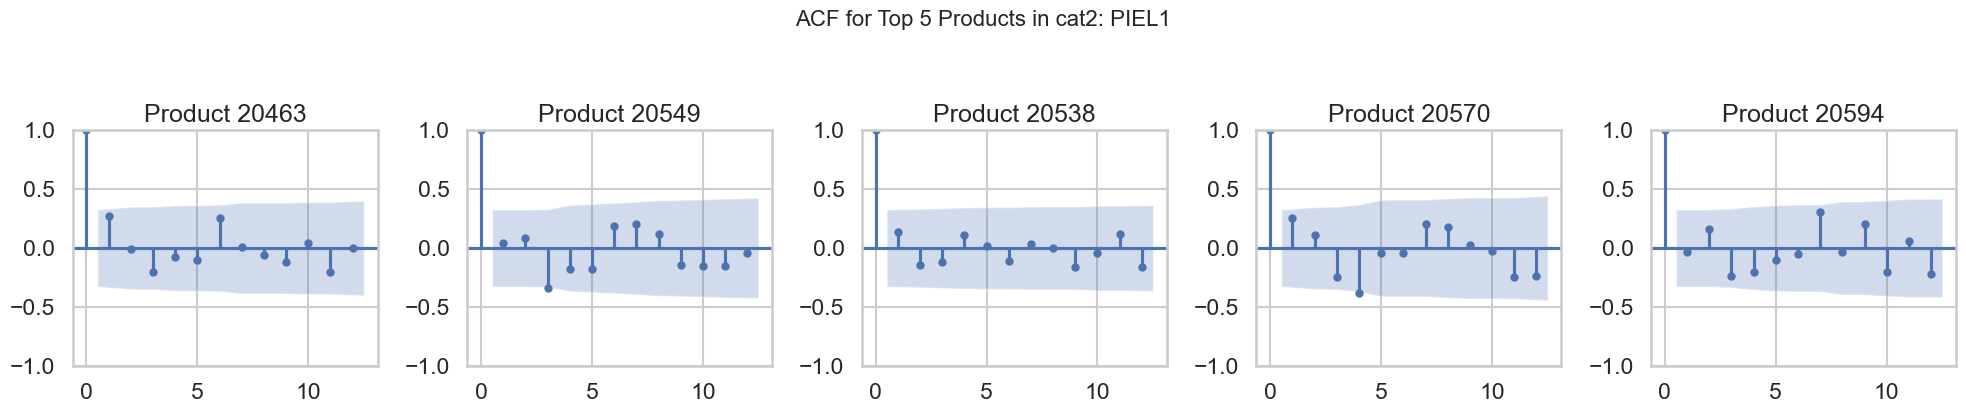

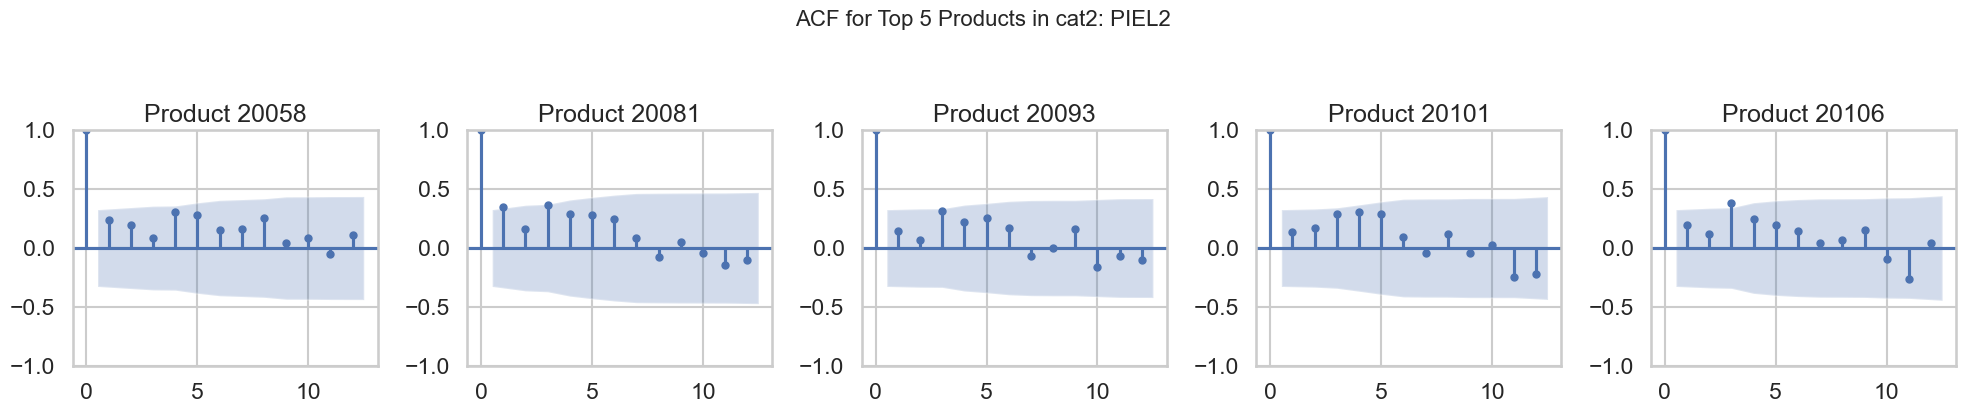

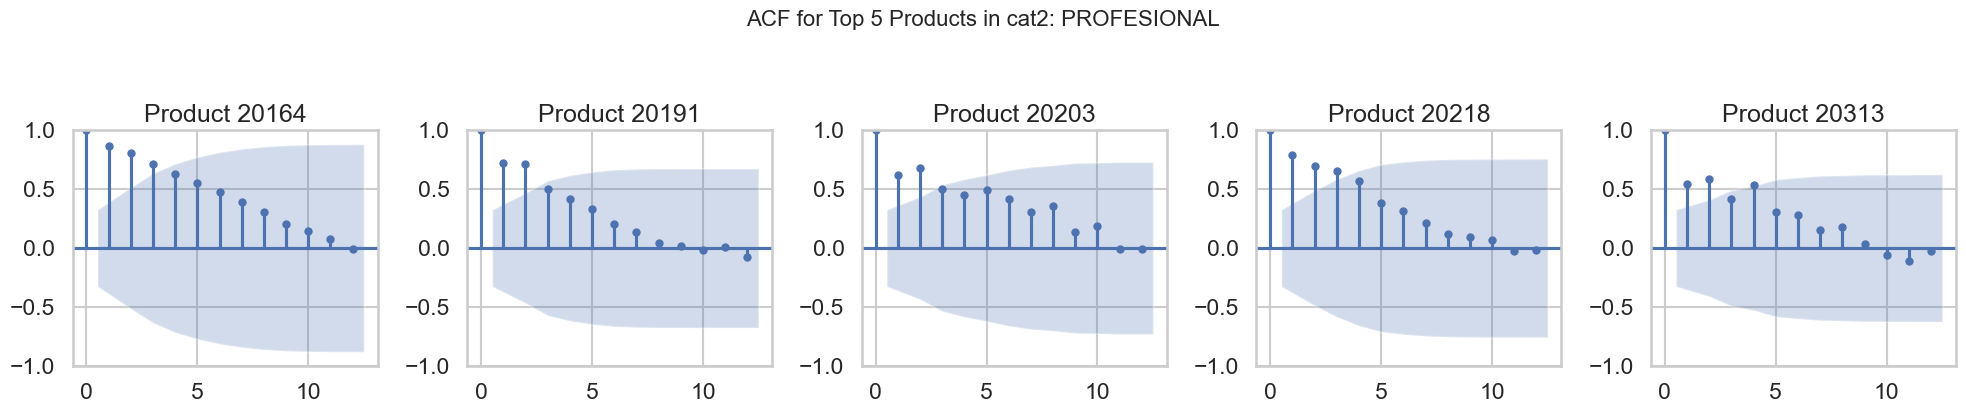

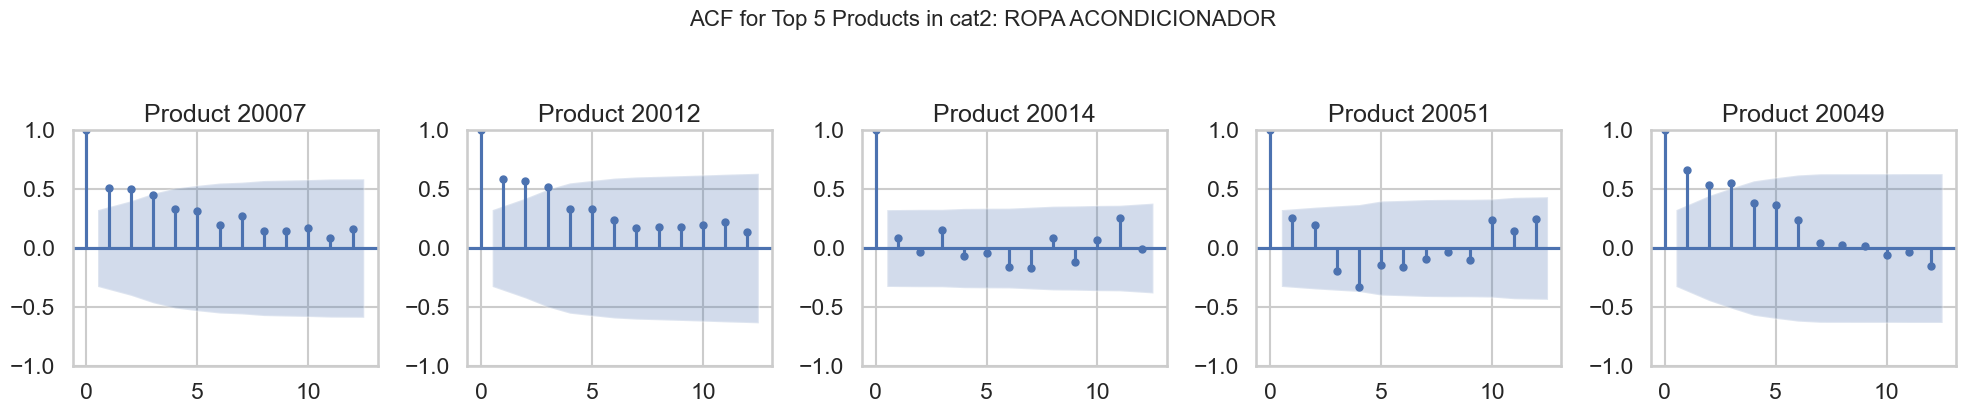

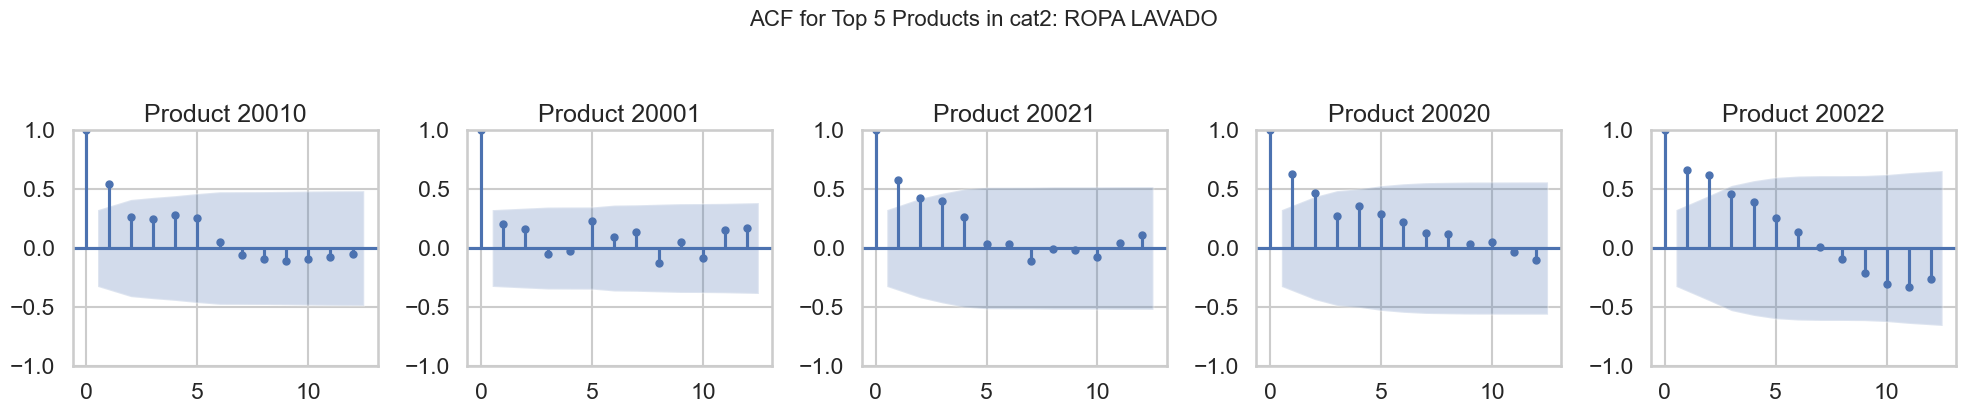

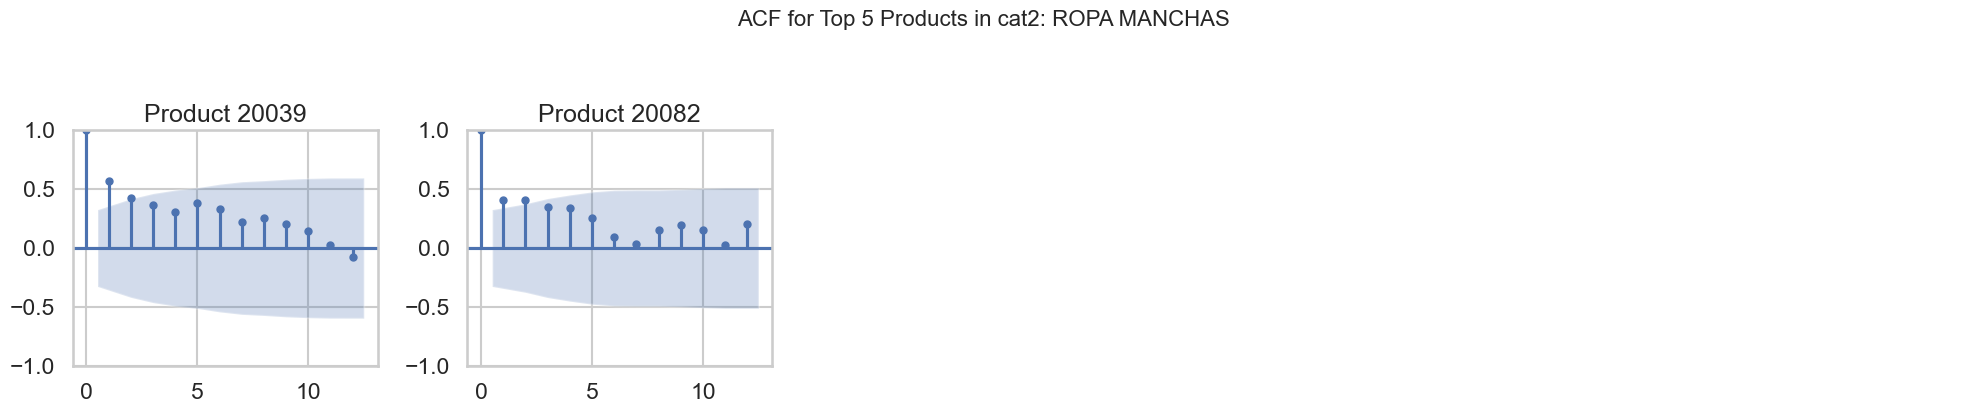

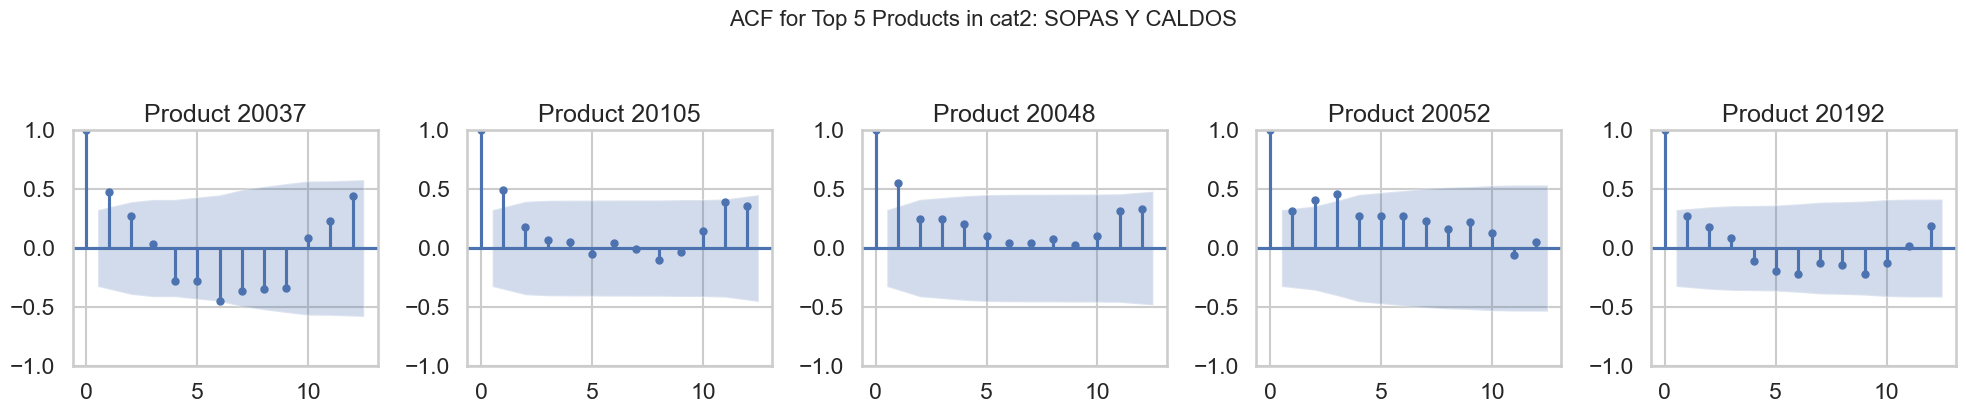

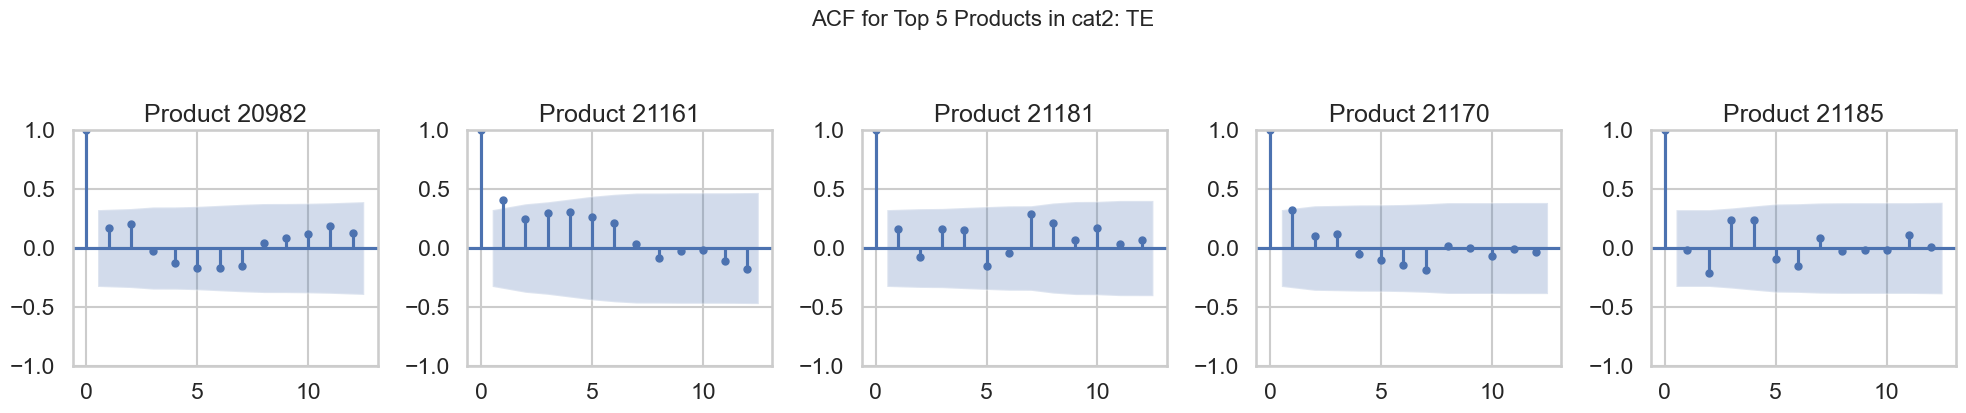

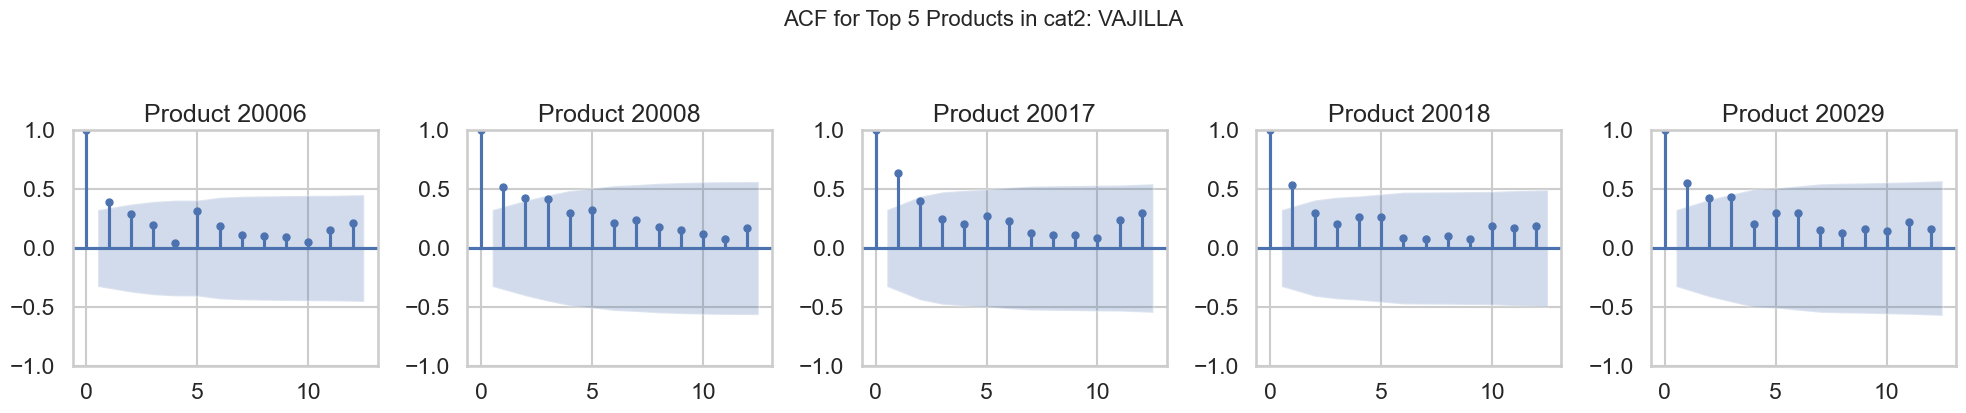

In [77]:
# Autocorrelation for products of each category

# Step 1: Aggregate monthly sales per product
monthly_sales = data.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# Step 2: Merge with cat2 info
monthly_sales = monthly_sales.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 3: Identify top 5 products by total sales per cat2
top_5_per_cat2 = (
    monthly_sales.groupby(['cat2', 'product_id'])['tn']
    .sum()
    .reset_index()
    .sort_values(['cat2', 'tn'], ascending=[True, False])
    .groupby('cat2')
    .head(5)
)

# Step 4: Loop over each cat2 and plot ACF for its top 5 products
cat2_list = top_5_per_cat2['cat2'].unique()

for cat2 in cat2_list:
    top_products = top_5_per_cat2[top_5_per_cat2['cat2'] == cat2]['product_id'].tolist()
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    
    for i, pid in enumerate(top_products):
        # Get time series for this product, reindexed to monthly frequency
        product_data = monthly_sales[monthly_sales['product_id'] == pid]
        product_series = (
            product_data.set_index('periodo')
            .resample('MS')['tn']
            .sum()
            .fillna(0)
            .reset_index(drop=True)
        )

        plot_acf(product_series, lags=12, ax=axes[i])
        axes[i].set_title(f'Product {pid}')

    # Turn off unused axes if less than 5
    for j in range(len(top_products), 5):
        axes[j].axis('off')

    fig.suptitle(f"ACF for Top 5 Products in cat2: {cat2}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

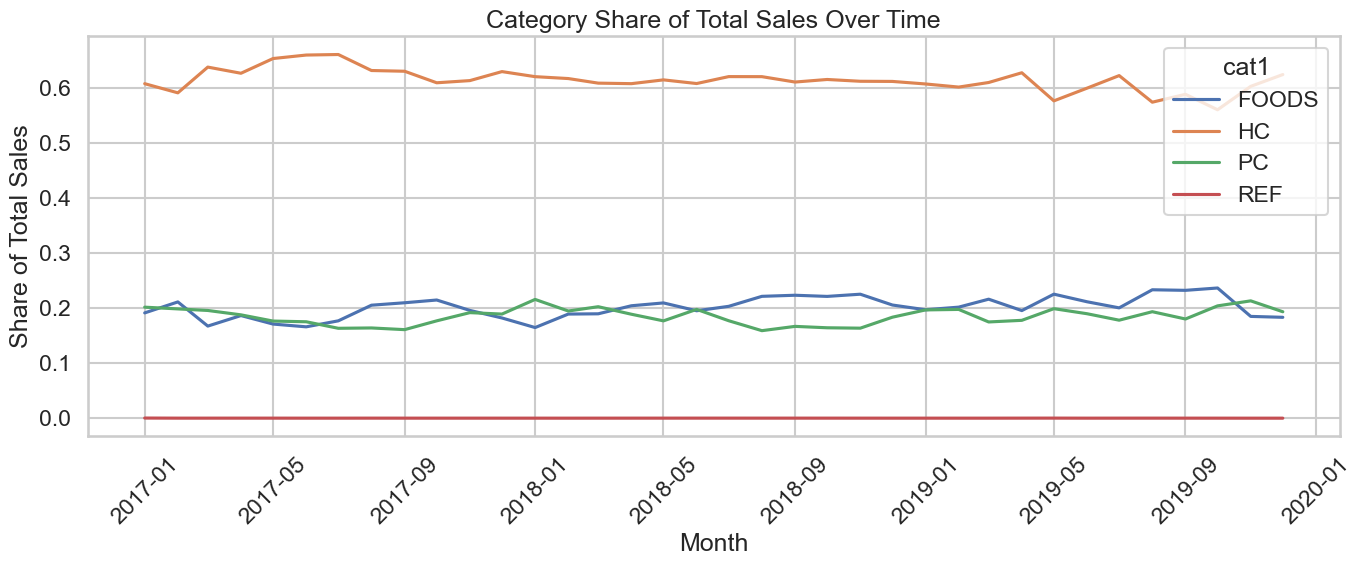

In [78]:
#Cat share over time

# Step 1: Aggregate total sales per period and category
monthly_cat_sales = data.groupby(['periodo', 'cat1'])['tn'].sum().reset_index()

# Step 2: Compute total sales per period
monthly_totals = monthly_cat_sales.groupby('periodo')['tn'].sum().reset_index(name='total_tn')

# Step 3: Merge to compute category share per period
monthly_cat_sales = monthly_cat_sales.merge(monthly_totals, on='periodo')
monthly_cat_sales['share'] = monthly_cat_sales['tn'] / monthly_cat_sales['total_tn']

# Step 4: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_cat_sales, x='periodo', y='share', hue='cat1')
plt.title("Category Share of Total Sales Over Time")
plt.ylabel("Share of Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [79]:
# Make sure data is sorted before creating lags
data = data.sort_values(['product_id', 'periodo'])

# Create lag_1 (previous month's sales per product)
data['lag_1'] = data.groupby('product_id')['tn'].shift(1)


lag_data = data[['tn', 'lag_1']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lag_data, x='lag_1', y='tn', alpha=0.5)
plt.title("Sales vs Lag 1 Sales")
plt.xlabel("Sales Last Month")
plt.ylabel("Current Sales")
plt.tight_layout()
plt.show()


In [80]:
correlation = lag_data['tn'].corr(lag_data['lag_1'])
print(f"Pearson correlation between tn and lag_1: {correlation:.3f}")


Pearson correlation between tn and lag_1: 0.950


## Identificacion de productos estacionales, trending, o ninguno

In [81]:


def classify_product(pid, df):
    series = df[df['product_id'] == pid].sort_values('periodo')['tn'].reset_index(drop=True)
    
    if len(series) < 13:
        return 'unknown'  # not enough data
    
    # ACF
    acfs = acf(series, nlags=12, fft=True)
    lag1, lag3, lag12 = acfs[1], acfs[3], acfs[12]
    
    # Monthly variation (seasonality)
    monthly_avg = df[df['product_id'] == pid].groupby(df['periodo'].dt.month)['tn'].mean()
    std = monthly_avg.std()
    mean = monthly_avg.mean()
    cv = std / (mean + 1e-6)
    
    # Trend detection (linear slope over time)
    slope = linregress(range(len(series)), series)[0]
    
    # Rule-based classification
    if lag12 > 0.3 or cv > 0.5:
        return 'seasonal'
    elif lag1 > 0.5 and lag3 > 0.3 and lag12 < 0.2 and abs(slope) > 0.01:
        return 'trending'
    else:
        return 'neither'


In [82]:
# Aplico a todos los productos
product_ids = data['product_id'].unique()
classifications = {pid: classify_product(pid, data) for pid in product_ids}

# Convert to DataFrame
product_types = pd.DataFrame.from_dict(classifications, orient='index', columns=['pattern_type']).reset_index()
product_types.rename(columns={'index': 'product_id'}, inplace=True)


In [83]:
# Combino con el dataset original
data = data.merge(product_types, on='product_id', how='left')


In [84]:
print(data.head(), "\n \n")
print(data['pattern_type'].value_counts())

     periodo  product_id          tn  stock_final cat1         cat2     cat3  \
0 2017-01-01       20001   934.77222          NaN   HC  ROPA LAVADO  Liquido   
1 2017-02-01       20001   798.01620          NaN   HC  ROPA LAVADO  Liquido   
2 2017-03-01       20001  1303.35771          NaN   HC  ROPA LAVADO  Liquido   
3 2017-04-01       20001  1069.96130          NaN   HC  ROPA LAVADO  Liquido   
4 2017-05-01       20001  1502.20132          NaN   HC  ROPA LAVADO  Liquido   

   brand  sku_size  stockout  month       lag_1 pattern_type  
0  ARIEL    3000.0     False      1         NaN      neither  
1  ARIEL    3000.0     False      2   934.77222      neither  
2  ARIEL    3000.0     False      3   798.01620      neither  
3  ARIEL    3000.0     False      4  1303.35771      neither  
4  ARIEL    3000.0     False      5  1069.96130      neither   
 

pattern_type
neither     18144
seasonal    16992
trending     9648
Name: count, dtype: int64


## Top selling products

In [85]:
# Step 1: Aggregate total sales per product
top_selling = (
    data.groupby('product_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'tn': 'total_sales_tn'})
)

# Step 2: Merge with product_info to get cat1, cat2, cat3
top_selling = top_selling.merge(
    product_info[['product_id', 'cat1', 'cat2', 'cat3']],
    on='product_id',
    how='left'
)

# Step 3: Display top 30 products
top_selling.head(30)



product_id  total_sales_tn   cat1                 cat2            cat3
0        20001     50340.39558     HC          ROPA LAVADO         Liquido
1        20010     37342.15836     HC          ROPA LAVADO           Polvo
2        20010     37342.15836     HC          ROPA LAVADO           Polvo
3        20002     36337.25439     HC          ROPA LAVADO         Liquido
4        20003     32004.15274  FOODS             ADEREZOS        Mayonesa
5        20021     25003.78252     HC          ROPA LAVADO           Polvo
6        20021     25003.78252     HC          ROPA LAVADO           Polvo
7        20020     24516.78008     HC          ROPA LAVADO           Polvo
8        20020     24516.78008     HC          ROPA LAVADO           Polvo
9        20004     24178.15379  FOODS             ADEREZOS        Mayonesa
10       20005     23191.21852  FOODS             ADEREZOS        Mayonesa
11       20007     22018.45234     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
12       20022     21387.99848     HC          ROPA LAVADO           Polvo
13       20022     21387.99848     HC          ROPA LAVADO           Polvo
14       20006     21088.76007     HC              VAJILLA      Cristalino
15       20008     19948.29352     HC              VAJILLA           Opaco
16       20012     17813.59935     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
17       20009     16891.02429     HC          ROPA LAVADO         Liquido
18       20014     16177.73435     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
19       20011     16085.40570     HC          ROPA LAVADO           Polvo
20       20013     15940.34442     HC                HOGAR         Cremoso
21       20015     14830.36374     HC          ROPA LAVADO         Liquido
22       20016     14351.40252     HC          ROPA LAVADO           Polvo
23       20019     13766.52294  FOODS             ADEREZOS        Mayonesa
24       20017     13495.98843     HC              VAJILLA           Opaco
25       20018     13178.80857     HC              VAJILLA      Cristalino
26       20037     12243.97840  FOODS       SOPAS Y CALDOS      Caldo Cubo
27       20037     12243.97840  FOODS       SOPAS Y CALDOS      Caldo Cubo
28       20024     10638.71172     HC          ROPA LAVADO           Polvo
29       20023     10435.28850  FOODS             ADEREZOS         Mostaza

### Analisis de clientes

In [86]:
top_clients = (
    sales.groupby('customer_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'tn': 'total_sales_tn'})
)

top_clients.head(20)


customer_id  total_sales_tn
0         10001    109203.60059
1         10002     77333.16887
2         10003     71375.91941
3         10004     63065.94269
4         10005     51467.04585
5         10006     49779.23364
6         10007     43740.39629
7         10008     41962.99046
8         10009     38742.71591
9         10011     34675.44337
10        10010     33834.46457
11        10012     30911.90724
12        10013     27291.52654
13        10014     17815.19560
14        10016     17302.55168
15        10015     17117.88649
16        10017     16408.09086
17        10018     15652.88449
18        10019     14611.49157
19        10020     12918.51572

In [87]:
top_client_ids = top_clients.head(5)['customer_id'].tolist()

client_time_series = (
    sales[sales['customer_id'].isin(top_client_ids)]
    .groupby(['periodo', 'customer_id'])['tn']
    .sum()
    .reset_index()
)


plt.figure(figsize=(14, 6))
sns.lineplot(data=client_time_series, x='periodo', y='tn', hue='customer_id')
plt.title("Monthly Sales from Top 5 Clients")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
client_product_matrix = (
    sales.groupby(['customer_id', 'product_id'])['tn']
    .sum()
    .unstack(fill_value=0)
)

# Keep top 10 clients and top 20 products only (optional)
top_client_ids = top_clients.head(10)['customer_id']
top_product_ids = data.groupby('product_id')['tn'].sum().nlargest(20).index

heatmap_data = client_product_matrix.loc[top_client_ids, top_product_ids]

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title("Sales Heatmap: Top Clients vs. Top Products")
plt.xlabel("Product ID")
plt.ylabel("Customer ID")
plt.tight_layout()
plt.show()


In [100]:
# Imprimir grafico de ventas por cliente y producto

# Select specific client and product
selected_customer = 10125
selected_product = 20524

# Filter the data
subset = sales[
    (sales['customer_id'] == selected_customer) &
    (sales['product_id'] == selected_product)
]

# Group by month and sum tn
monthly_sales = (
    subset.groupby('periodo')['tn']
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=monthly_sales, x='periodo', y='tn', color='steelblue')
plt.title(f"Sales to Customer {selected_customer} of Product {selected_product}")
plt.xlabel("Month")
plt.ylabel("Tons (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analisis de precios cuidados

In [89]:
product_counts = (
    sales.groupby(['product_id', 'plan_precios_cuidados'])['tn']
    .sum()
    .reset_index()
    .groupby('plan_precios_cuidados')['product_id']
    .nunique()
)

print(product_counts)


plan_precios_cuidados
0    1233
1      42
Name: product_id, dtype: int64


In [90]:
total_sales_by_plan = (
    sales.groupby('plan_precios_cuidados')['tn']
    .sum()
    .reset_index()
)


total_sales_by_plan


plan_precios_cuidados            tn
0                      0  1.314988e+06
1                      1  1.000090e+04

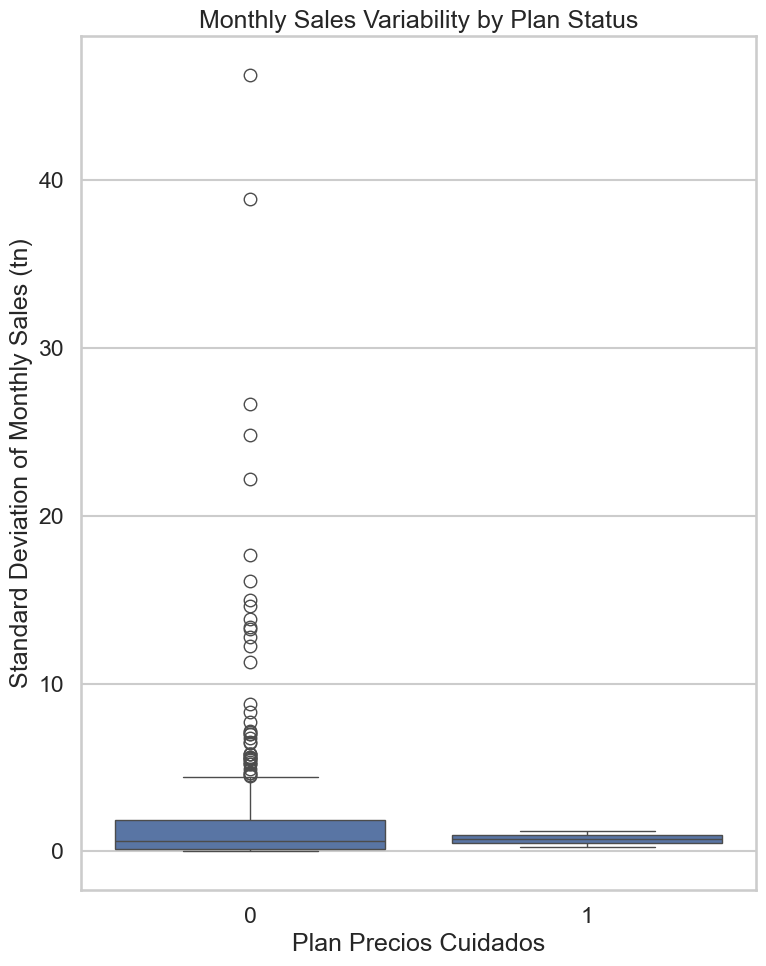

In [91]:
monthly_variability = (
    sales.groupby(['product_id', 'plan_precios_cuidados', data['periodo'].dt.to_period('M')])['tn']
    .sum()
    .reset_index()
)

variability = (
    monthly_variability
    .groupby(['product_id', 'plan_precios_cuidados'])['tn']
    .std()
    .reset_index()
)

plt.figure(figsize=(8, 10))
sns.boxplot(data=variability, x='plan_precios_cuidados', y='tn')
plt.title("Monthly Sales Variability by Plan Status")
plt.xlabel("Plan Precios Cuidados")
plt.ylabel("Standard Deviation of Monthly Sales (tn)")
plt.tight_layout()
plt.show()


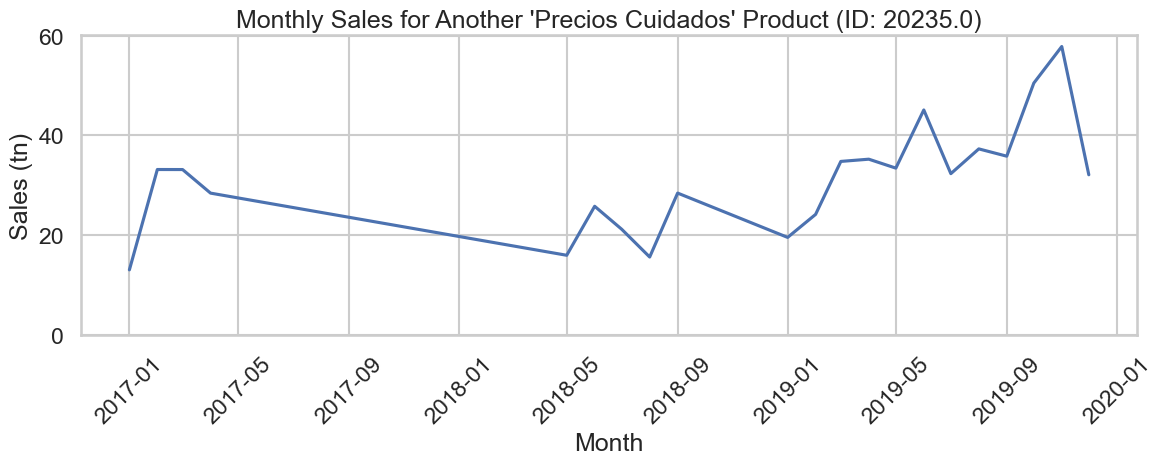

In [92]:
# Filter products in the Precios Cuidados plan
pc_data = sales[sales['plan_precios_cuidados'] == 1]

# Step 2: Get top N products in the plan
top_pc_products = (
    pc_data.groupby('product_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Pick the 2nd product (change .iloc[1] to .iloc[2], .iloc[3] etc. for others)
second_product_id = top_pc_products.iloc[3]['product_id']

# Step 3: Filter data for that product
product_data = pc_data[pc_data['product_id'] == second_product_id].copy()
product_data['month'] = product_data['periodo'].dt.to_period('M').dt.to_timestamp()

# Step 4: Aggregate monthly sales
monthly_sales = (
    product_data.groupby('month')['tn']
    .sum()
    .reset_index()
)

# Step 5: Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='month', y='tn')
plt.title(f"Monthly Sales for Another 'Precios Cuidados' Product (ID: {second_product_id})")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

### Analisis de presentaciones

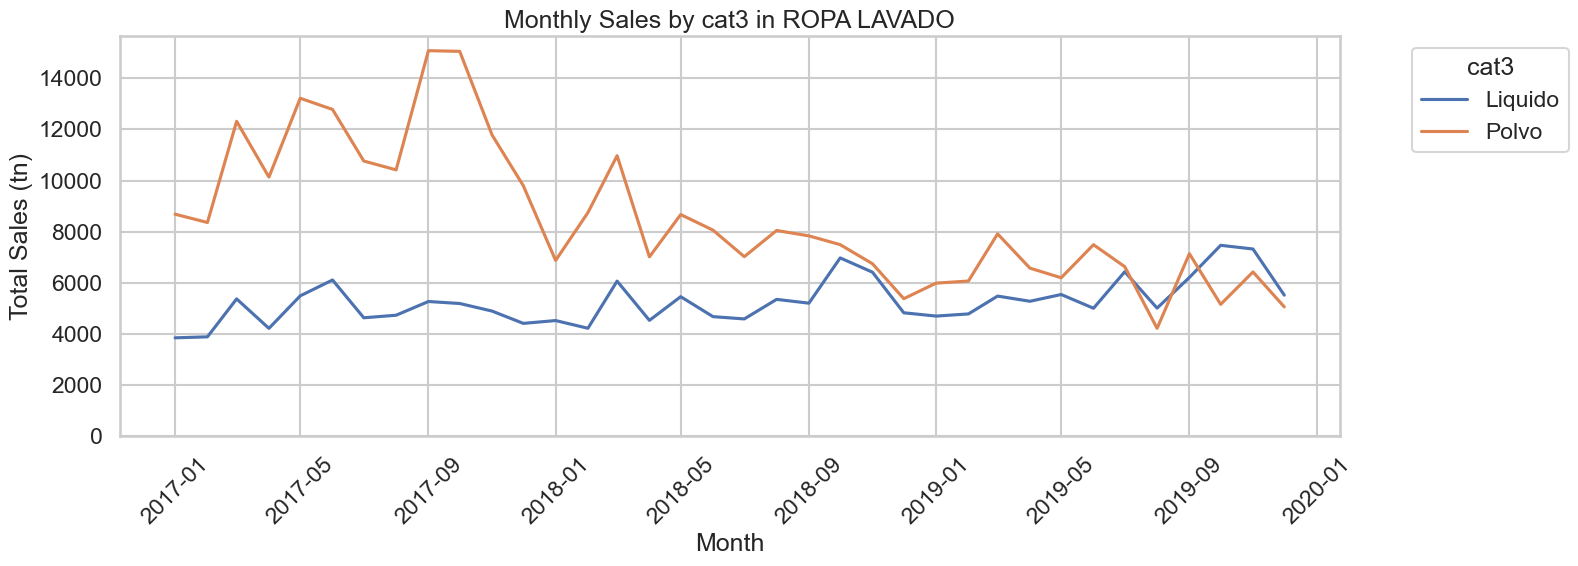

In [93]:
# Step 1: Merge product info to bring in cat2 and cat3
data_with_cat = sales.merge(product_info[['product_id', 'cat2', 'cat3']], on='product_id', how='left')

# Step 2: Filter for cat2 = 'ROPA LAVADO'
ropa_data = data_with_cat[data_with_cat['cat2'] == 'ROPA LAVADO'].copy()

# Step 3: Add 'month' column
ropa_data['month'] = ropa_data['periodo'].dt.to_period('M').dt.to_timestamp()

# Step 4: Group by month and cat3, sum tn
monthly_cat3_sales = (
    ropa_data.groupby(['month', 'cat3'])['tn']
    .sum()
    .reset_index()
)

# Step 5: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_cat3_sales, x='month', y='tn', hue='cat3')
plt.title("Monthly Sales by cat3 in ROPA LAVADO")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.legend(title='cat3', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [94]:
# Analisis por liquido concentrado y diluido

# Step 1: Filter for ROPA LAVADO → Liquido
ropa_liquido = sales.merge(
    product_info[['product_id', 'cat2', 'cat3']], 
    on='product_id', how='left'
)

ropa_liquido = ropa_liquido[
    (ropa_liquido['cat2'] == 'ROPA LAVADO') & 
    (ropa_liquido['cat3'] == 'Liquido')
].copy()

# ✅ Step 2: Filter rows where tn == cust_request_tn
ropa_liquido = ropa_liquido[ropa_liquido['tn'].round(4) == ropa_liquido['cust_request_tn'].round(4)]

# Step 3: Aggregate tn and quantity per product
summary = ropa_liquido.groupby('product_id')[['tn', 'cust_request_qty']].sum().reset_index()

# Step 4: Calculate kg per unit
summary['kg_per_unit'] = (summary['tn'] * 1000) / (summary['cust_request_qty'] + 1e-6)

# Step 5: Display likely concentrated/diluted products
summary_sorted = summary.sort_values('kg_per_unit')

print("🚿 Likely Concentrated Products (lighter per unit):")
print(summary_sorted.head(10))

print("\n🧴 Likely Diluted Products (heavier per unit):")
print(summary_sorted.tail(10))



🚿 Likely Concentrated Products (lighter per unit):
    product_id         tn  cust_request_qty  kg_per_unit
48       20919   46.58825              2894    16.098220
47       20897   64.29511              1264    50.866384
44       20731  133.83807              2424    55.213725
38       20493  373.87844              6219    60.118739
39       20507  360.93475              5812    62.101643
45       20780  107.77861              1580    68.214310
36       20439  462.76626              6248    74.066303
42       20635  205.71917              2647    77.717858
43       20682  139.51407              1729    80.690613
29       20332  624.42053              7654    81.580942

🧴 Likely Diluted Products (heavier per unit):
    product_id           tn  cust_request_qty  kg_per_unit
4        20026   8559.76681             11605   737.593004
7        20085   2368.89174              3143   753.704021
9        20098   3688.07123              4764   774.154330
3        20015  12205.39866            

In [95]:
# STEP 1: Filter for ROPA LAVADO → Liquido, where tn == cust_request_tn
ropa_liquido = sales.merge(
    product_info[['product_id', 'cat2', 'cat3']], 
    on='product_id', how='left'
)

ropa_liquido = ropa_liquido[
    (ropa_liquido['cat2'] == 'ROPA LAVADO') &
    (ropa_liquido['cat3'] == 'Liquido') &
    (ropa_liquido['tn'].round(4) == ropa_liquido['cust_request_tn'].round(4))
].copy()

# STEP 2: Calculate average kg per unit per product
summary = ropa_liquido.groupby('product_id')[['tn', 'cust_request_qty']].sum().reset_index()
summary['kg_per_unit'] = (summary['tn'] * 1000) / (summary['cust_request_qty'] + 1e-6)

# STEP 3: Tag products
threshold = 1  # kg/unit
summary['concentration_type'] = summary['kg_per_unit'].apply(
    lambda x: 'Concentrated' if x <= threshold else 'Diluted'
)

# STEP 4: Merge tag back
ropa_liquido = ropa_liquido.merge(summary[['product_id', 'concentration_type']], on='product_id', how='left')

# STEP 5: Add month column
ropa_liquido['month'] = ropa_liquido['periodo'].dt.to_period('M').dt.to_timestamp()

# STEP 6: Group by month and concentration type using quantity
monthly_units = (
    ropa_liquido.groupby(['month', 'concentration_type'])['cust_request_qty']
    .sum()
    .reset_index()
)

# STEP 7: Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_units, x='month', y='cust_request_qty', hue='concentration_type')
plt.title("Monthly Units Sold: Concentrated vs. Diluted (ROPA LAVADO → Liquido)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.legend(title="Type")
plt.show()